# Using the XBBG module to extract and analyze historic bond data for corporate hybrids for a *specific* issuer

# written by: Darren Lefcoe
Aug 2020

contact:
* gitHub: @dlefcoe
* twitter: @dlefcoe
* email: darren@redhedge.uk


## Redhedge Asset Management

Darren Lefcoe uses open source to create and write code for RedHedge.

Running an open source project, like any human endeavor, involves uncertainty and trade-offs.

Please refer to the open source licences:
https://opensource.guide/notices/


# First we do the imports

In [1]:
import os
import sys

import time
import datetime
import collections

import blpapi
from xbbg import blp


import openpyxl
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import linear_model
import numpy as np

import pandas_profiling #something new

import imgkit # for styling
import dateutil # possibly not needed


In [2]:
# get the file path of this file
dir_path = os.path.abspath('')
print(dir_path)



C:\Users\darren\OneDrive - Redhedge\code\bbg\corpHybrids


In [3]:
# define a list of bond fields for CURRENT data
field_list_current = ['id_isin','ticker', 'coupon', 'nxt_call_dt', 'final_maturity', 
            'mty_typ', 'px_mid', 'z_sprd_mid', 'yas_ispread', 'yas_bond_yld', 
            'yas_risk','crncy', 'payment_rank', 'industry_sector','rtg_moody',
             'rtg_sp','yas_mod_dur','workout_dt_years_tdy','reset_idx','basic_spread', 'amt_outstanding']
fieldList = field_list_current

# define a list of bond fields for HISTORIC data
field_list_history = ['px_mid','z_sprd_mid','blp_i_sprd_mid']

In [4]:
# corporate ticker to use
corporate_ticker = 'total'

# note this ticker must be in both [1] the isin_dict and [2] the corp_bench_isin dictionary

In [5]:
# list of isins (in the new version this should be a dictionary)

isin_dict = {'vw':['XS1048428012', 'XS1206540806', 'XS1629658755', 'XS0968913342', 'XS1799938995', 
                'XS2187689034', 'XS1048428442', 'XS1629774230', 'XS1799939027', 'XS2187689380', 'XS1206541366'],
             'telefo':['XS1490960942','XS1731823255','XS1795406575','XS1050461034','XS1933828433',
                    'XS1795406658','XS2109819859','XS2056371334'],
             'total':['XS1195201931','XS1413581205','XS1501167164','XS1974787480','XS1195202822','XS1501166869']
            }

all_VW_bonds = isin_dict['vw'] #can remove
all_telefo_bonds = isin_dict['telefo'] #can remove

isin_list = isin_dict[corporate_ticker]
print(isin_list)


['XS1195201931', 'XS1413581205', 'XS1501167164', 'XS1974787480', 'XS1195202822', 'XS1501166869']


In [6]:
# benchmark

# dict containing tickers and benchmarks
corp_bench_isin = {'vw':'XS1048428442', 'telefo':'XS1795406658', 'total':'XS1195202822'}

vw_benchmark_isin = corp_bench_isin['vw'] # can remove
telefo_benchmark_isin = corp_bench_isin['telefo'] #can remove

# select an appropriate benchmark isin
benchmark_bond_isin = corp_bench_isin[corporate_ticker]
print(benchmark_bond_isin)

XS1195202822


# A function to get the bond data

In [7]:
def getListDataFromBbg(securtiyList, fieldList):
    ''' 
    gets data from bloomberg using a while loop until completion

        inputs:
            securtiyList - list of tickers to obtain
            fieldList - the fields requested for each ticker

        output:
            resultsOfDataReq - resulting pandas array of the data that was requested

    '''
    # get the data (bdp returns a dataframe)
    resultsOfDataReq = blp.bdp(tickers=securtiyList, flds=fieldList)

    
    #pre-loop initialization
    keepLooping = True
    loopingCounter = 0
    while keepLooping:
        
        # check which items are missing
        listError = list(set(securtiyList)-set(resultsOfDataReq.index.values))
        
        if len(listError) == 0:
            # data collection process finished
            keepLooping = False
            break
        else:
            print(len(listError), 'of', len(securtiyList), 'remaining', ': loop', loopingCounter)
            loopingCounter += 1
            if loopingCounter > 10:
                # more than 10 tries at data collection
                keepLooping = False
                break

        # get and append more data
        try:
            nextChunk = blp.bdp(tickers=listError, flds=fieldList)
            resultsOfDataReq = resultsOfDataReq.append(nextChunk)
        except:
            print('no data to add')

        # remove duplicates
        resultsOfDataReq = resultsOfDataReq.drop_duplicates()

    return resultsOfDataReq


    

# There are 2 ways of getting history

- from bloomberg
- from a file


## Get historic bond data from BBG




In [8]:
def getHistoryFromISIN(isin: str, fieldList: list):
    '''
    function that takes an isin as a string and returns a DataFrame for the ISIN
    
    '''

    # get dates to use (in the correct format)
    dateToUseToday = datetime.date.today()
    dateToUse2yAgo = dateToUseToday + datetime.timedelta(days=-365*2)
    
    print('lets go between today and 2 years ago')
    print('today:', dateToUseToday)
    print('2y ago:', dateToUse2yAgo)

    # fields that we want to get
    fieldList = fieldList #['px_bid', 'px_ask', 'blp_i_sprd_mid']
    #fieldList = ['blp_i_sprd_mid']

    # request from bbg returning a MultiIndex DataFrame object    
    bondDataHist = blp.bdh(
        tickers= isin+' Corp', flds=fieldList,
        start_date=dateToUse2yAgo, end_date=dateToUseToday,
        )


    return bondDataHist

# try on function on the benchmark bond
bondDataHist = getHistoryFromISIN(benchmark_bond_isin, fieldList=field_list_history)
display(bondDataHist)





lets go between today and 2 years ago
today: 2020-08-26
2y ago: 2018-08-27


XS1195202822 Corp                          
                      px_mid z_sprd_mid blp_i_sprd_mid
2018-08-27           101.731    185.908        183.737
2018-08-28           101.759    185.559        183.473
2018-08-29           101.648    185.587        183.360
2018-08-30           101.530    190.095        188.273
2018-08-31           101.357    194.443        192.379
...                      ...        ...            ...
2020-08-20           105.250    182.255        182.047
2020-08-21           105.239    183.263        183.144
2020-08-24           105.331    180.716        180.620
2020-08-25           105.353    177.339        177.086
2020-08-26           105.204        NaN            NaN

[511 rows x 3 columns]

#### get the average spread

In [9]:

print('the mean is: \n', bondDataHist.mean())
print('\nthe standard deviation is:\n', bondDataHist.std())
#x['blp_i_sprd_mid'].mean()

the mean is: 
 XS1195202822 Corp  px_mid            104.073771
                   z_sprd_mid        189.496833
                   blp_i_sprd_mid    188.637794
dtype: float64

the standard deviation is:
 XS1195202822 Corp  px_mid             3.874748
                   z_sprd_mid        68.306529
                   blp_i_sprd_mid    68.410038
dtype: float64


### plot a time series for the spreads






the type of data:  <class 'pandas.core.frame.DataFrame'>
MultiIndex([('XS1195202822 Corp',         'px_mid'),
            ('XS1195202822 Corp',     'z_sprd_mid'),
            ('XS1195202822 Corp', 'blp_i_sprd_mid')],
           )
the mean value is: 188.63779411764705


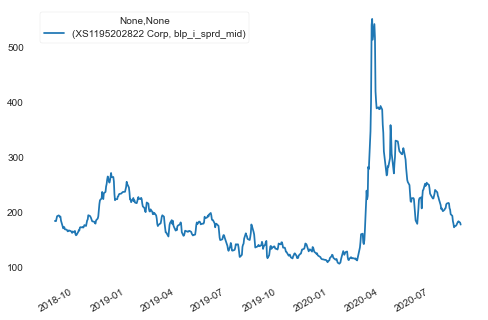

In [10]:
# plot just spread
print('the type of data: ',type(bondDataHist))

# works
bondDataHist.plot(y=(benchmark_bond_isin+' Corp', 'blp_i_sprd_mid'))

# note this is a multi index
print(bondDataHist.columns)

x = bondDataHist[(benchmark_bond_isin+' Corp', 'blp_i_sprd_mid')]
print('the mean value is:',x.mean())


### EuroSwaps

In [11]:
eurSwp_sec_list = ['EUSA'+ str(x) + ' BGN Curncy' for x in range(1,20)]  #['EUSA5 BGN Curncy']
eurSwp_field_list = ['ticker','px_last','maturity'] 
euroSwaps_df = getListDataFromBbg(eurSwp_sec_list, eurSwp_field_list)
euroSwaps_df

ticker px_last    maturity
EUSA1 BGN Curncy    EUSA1 -0.4374  2021-08-28
EUSA10 BGN Curncy  EUSA10 -0.1575  2030-08-28
EUSA11 BGN Curncy  EUSA11  -0.114  2031-08-28
EUSA12 BGN Curncy  EUSA12  -0.072  2032-08-28
EUSA13 BGN Curncy  EUSA13 -0.0336  2033-08-28
EUSA14 BGN Curncy  EUSA14  0.0004  2034-08-28
EUSA15 BGN Curncy  EUSA15  0.0296  2035-08-28
EUSA16 BGN Curncy  EUSA16  0.0541  2036-08-28
EUSA17 BGN Curncy  EUSA17   0.074  2037-08-28
EUSA18 BGN Curncy  EUSA18   0.089  2038-08-28
EUSA19 BGN Curncy  EUSA19  0.0998  2039-08-28
EUSA2 BGN Curncy    EUSA2 -0.4275  2022-08-28
EUSA3 BGN Curncy    EUSA3 -0.4128  2023-08-28
EUSA4 BGN Curncy    EUSA4 -0.3892  2024-08-28
EUSA5 BGN Curncy    EUSA5 -0.3602  2025-08-28
EUSA6 BGN Curncy    EUSA6 -0.3256  2026-08-28
EUSA7 BGN Curncy    EUSA7 -0.2866  2027-08-28
EUSA8 BGN Curncy    EUSA8  -0.245  2028-08-28
EUSA9 BGN Curncy    EUSA9 -0.2023  2029-08-28

## get data for multiple bonds




In [12]:
# not needed. General formula used
# all_VW_bonds = ['XS1048428012', 'XS1206540806', 'XS1629658755', 'XS0968913342', 'XS1799938995', 
#                 'XS2187689034', 'XS1048428442', 'XS1629774230', 'XS1799939027', 'XS2187689380', 'XS1206541366']

# all_telefo_bonds = ['XS1490960942','XS1731823255','XS1795406575','XS1050461034','XS1933828433',
#                     'XS1795406658','XS2109819859','XS2056371334']

listOfBonds = isin_list
print(listOfBonds)


['XS1195201931', 'XS1413581205', 'XS1501167164', 'XS1974787480', 'XS1195202822', 'XS1501166869']


In [13]:
def getHistoryFromISIN_list(isin_list: list):
    ''' function to get historic data from a list of isins  '''

    # list of isins
    isin_list = [i + ' Corp' for i in isin_list]
    print('here is the list: ', isin_list)

    # fields
    fieldList = 'blp_i_sprd_mid'

    # start and end dates to use
    dateToUseToday = datetime.date.today()
    dateToUse2yAgo = dateToUseToday + datetime.timedelta(days=-365*2)
    
    print('lets go between today and 2 years ago')
    print('today:', dateToUseToday)
    print('2y ago:', dateToUse2yAgo)



    # request from bbg returning a MultiIndex DataFrame object    
    bondDataHist = blp.bdh(
        tickers= isin_list, flds=fieldList,
        start_date=dateToUse2yAgo, end_date=dateToUseToday,
        )
    

    return bondDataHist

bond_isprd_hist = getHistoryFromISIN_list(listOfBonds)
bond_isprd_hist


here is the list:  ['XS1195201931 Corp', 'XS1413581205 Corp', 'XS1501167164 Corp', 'XS1974787480 Corp', 'XS1195202822 Corp', 'XS1501166869 Corp']
lets go between today and 2 years ago
today: 2020-08-26
2y ago: 2018-08-27


XS1195201931 Corp XS1195202822 Corp XS1413581205 Corp  \
              blp_i_sprd_mid    blp_i_sprd_mid    blp_i_sprd_mid   
2018-08-27           118.615           183.737           146.843   
2018-08-28           117.210           183.473           145.952   
2018-08-29           118.132           183.360           147.876   
2018-08-30           122.575           188.273           152.732   
2018-08-31           126.319           192.379           156.627   
...                      ...               ...               ...   
2020-08-19            92.447           179.902           111.163   
2020-08-20           101.326           182.047           111.071   
2020-08-21           105.612           183.144           112.039   
2020-08-24            99.445           180.620           110.025   
2020-08-25            99.498           177.086           107.705   

           XS1501166869 Corp XS1501167164 Corp XS1974787480 Corp  
              blp_i_sprd_mid    blp_i_sprd_mid    blp_i_sprd_mid  
2018-08-27           201.456           154.101               NaN  
2018-08-28           200.606           153.449               NaN  
2018-08-29           199.890           154.262               NaN  
2018-08-30           205.310           162.692               NaN  
2018-08-31           208.386           166.324               NaN  
...                      ...               ...               ...  
2020-08-19           175.882           140.676           164.845  
2020-08-20           178.719           142.625           166.758  
2020-08-21           180.126           143.873           167.611  
2020-08-24           177.630           142.045           165.488  
2020-08-25           172.899           140.023           161.890  

[510 rows x 6 columns]

In [14]:
bond_isprd_hist.describe()


XS1195201931 Corp XS1195202822 Corp XS1413581205 Corp XS1501166869 Corp  \
         blp_i_sprd_mid    blp_i_sprd_mid    blp_i_sprd_mid    blp_i_sprd_mid   
count        510.000000        510.000000        510.000000        510.000000   
mean         125.316004        188.637794        143.651171        194.168986   
std           92.987510         68.410038         82.212087         54.718685   
min           40.068000        105.918000         58.424000        114.118000   
25%           66.098750        138.207250         90.395750        151.202500   
50%           96.614500        177.107500        121.386500        188.966000   
75%          156.940000        221.348250        168.967250        226.479000   
max          676.575000        551.535000        665.659000        432.698000   

      XS1501167164 Corp XS1974787480 Corp  
         blp_i_sprd_mid    blp_i_sprd_mid  
count        510.000000        359.000000  
mean         159.260525        173.711493  
std           70.586069         79.174651  
min           79.577000         93.337000  
25%          108.691500        120.267500  
50%          141.462000        147.310000  
75%          187.929750        199.309500  
max          536.924000        540.895000

In [15]:
# prep & deploy the pandas profile module

# create new df and then drop multiindex from new df (required for pandas_profiling)
bond_singleIndex = bond_isprd_hist.copy()
bond_singleIndex.columns = bond_singleIndex.columns.droplevel(level=1)
# bond_singleIndex

# pandas profiling
pandas_profiling.ProfileReport(bond_singleIndex)


In [16]:
#extracting data from the DataFrame
#print(bond_isprd_hist.describe().iloc[0]) # works
#print(bond_isprd_hist.describe().loc['max']) # works

# get the max of one bond
print('the max is ', bond_isprd_hist.describe().loc[['max'],[(listOfBonds[0]+' Corp',  'blp_i_sprd_mid')]].values)


the max is  [[676.575]]


In [17]:
# save to csv

# time stamp & path etc.
ts = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
fileToSave = 'bond_isprd_HistoryStats ' + ts + '.csv'
fileToSave = os.path.join(os.path.abspath(''), 'dataFolder', 'csvData', fileToSave)

# export to csv
bond_isprd_hist.describe().to_csv(fileToSave)
print('file saved here: ', fileToSave)


file saved here:  C:\Users\darren\OneDrive - Redhedge\code\bbg\corpHybrids\dataFolder\csvData\bond_isprd_HistoryStats 2020-08-26 16_55_15.csv


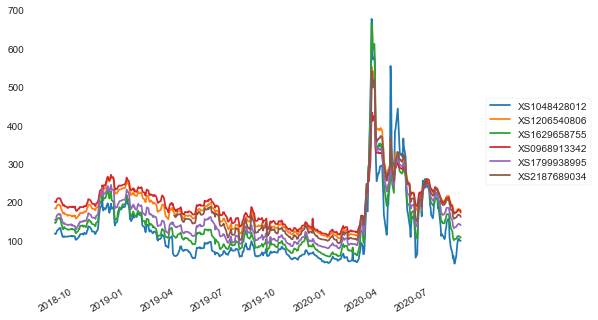

In [18]:
## do some basic stats

# print(bond_isprd_hist.columns)
# print('the means:')
# print(bond_isprd_hist.mean())
# print('the st devs:')
# print(bond_isprd_hist.std())

bond_isprd_hist.plot().legend(all_VW_bonds, loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()


# We need the current data (for the names instead of isins)

In [19]:
def get_CorpBondData(isin_list: list, fieldList: list):
    ''' 
    function to get bond data
    
        input:
            isin_list: list of isins
            fieldList: list of valid fields to request
    
        output:
            df: dataframe of bloomberg data
    '''

    # isins
    isin_list = [i + " Corp" for i in isin_list]

    df = getListDataFromBbg(isin_list,  fieldList)


    return df


bond_df = get_CorpBondData(isin_list=listOfBonds, fieldList=field_list_current)
print(listOfBonds)
bond_df

['XS1195201931', 'XS1413581205', 'XS1501167164', 'XS1974787480', 'XS1195202822', 'XS1501166869']


id_isin ticker coupon nxt_call_dt    mty_typ   px_mid  \
XS1195201931 Corp  XS1195201931  TOTAL   2.25  2021-02-26  PERP/CALL  100.786   
XS1195202822 Corp  XS1195202822  TOTAL  2.625  2025-02-26  PERP/CALL  105.206   
XS1413581205 Corp  XS1413581205  TOTAL  3.875  2022-05-18  PERP/CALL  105.454   
XS1501166869 Corp  XS1501166869  TOTAL  3.369  2026-10-06  PERP/CALL  111.355   
XS1501167164 Corp  XS1501167164  TOTAL  2.708  2023-05-05  PERP/CALL  104.502   
XS1974787480 Corp  XS1974787480  TOTAL   1.75  2024-04-04  PERP/CALL  101.791   

                  z_sprd_mid yas_ispread yas_bond_yld  yas_risk crncy  \
XS1195201931 Corp     110.58     109.817     0.655782  0.505156   EUR   
XS1195202822 Corp    179.762     179.538      1.42087   4.47017   EUR   
XS1413581205 Corp    110.628     110.517     0.674437   1.78243   EUR   
XS1501166869 Corp    174.259     173.616      1.41456   6.20575   EUR   
XS1501167164 Corp    141.772     141.669     0.999179    2.7211   EUR   
XS1974787480 Corp    163.649     163.591      1.23738   3.54248   EUR   

                      payment_rank industry_sector rtg_moody rtg_sp  \
XS1195201931 Corp  Jr Subordinated          Energy        A2     A-   
XS1195202822 Corp  Jr Subordinated          Energy        A2     A-   
XS1413581205 Corp  Jr Subordinated          Energy        A2     A-   
XS1501166869 Corp  Jr Subordinated          Energy        A2     A-   
XS1501167164 Corp  Jr Subordinated          Energy        A2     A-   
XS1974787480 Corp  Jr Subordinated          Energy        A2     A-   

                  yas_mod_dur workout_dt_years_tdy reset_idx basic_spread  \
XS1195201931 Corp    0.495651             0.503765     EUSA5        1.861   
XS1195202822 Corp     4.19635              4.50376     EUSA5        2.148   
XS1413581205 Corp     1.67307              1.72485     EUSA5        3.783   
XS1501166869 Corp     5.42626              6.11088     EUSA5         3.35   
XS1501167164 Corp     2.58279              2.68857     EUSA5         2.75   
XS1974787480 Corp     3.45636              3.60575     EUSA5        1.765   

                  amt_outstanding  
XS1195201931 Corp           1e+09  
XS1195202822 Corp         2.5e+09  
XS1413581205 Corp        1.75e+09  
XS1501166869 Corp         1.5e+09  
XS1501167164 Corp           1e+09  
XS1974787480 Corp         1.5e+09

In [20]:
# add a unique name
bond_df['uniqueName'] = bond_df['ticker'] +  " " + bond_df['coupon'].astype(str) + " -c " + bond_df['nxt_call_dt'].astype(str).str[2:4]


# add reset index value
bond_df['reset_idx value'] = [euroSwaps_df.loc[x+' BGN Curncy','px_last'] for x in bond_df['reset_idx']]

# compute reset coupon
bond_df['reset coupon'] = bond_df['reset_idx value'] + bond_df['basic_spread']

print('average reset cpn:', bond_df['reset coupon'].mean())

display(bond_df)

average reset cpn: 2.249299994913737


id_isin ticker coupon nxt_call_dt    mty_typ   px_mid  \
XS1195201931 Corp  XS1195201931  TOTAL   2.25  2021-02-26  PERP/CALL  100.786   
XS1195202822 Corp  XS1195202822  TOTAL  2.625  2025-02-26  PERP/CALL  105.206   
XS1413581205 Corp  XS1413581205  TOTAL  3.875  2022-05-18  PERP/CALL  105.454   
XS1501166869 Corp  XS1501166869  TOTAL  3.369  2026-10-06  PERP/CALL  111.355   
XS1501167164 Corp  XS1501167164  TOTAL  2.708  2023-05-05  PERP/CALL  104.502   
XS1974787480 Corp  XS1974787480  TOTAL   1.75  2024-04-04  PERP/CALL  101.791   

                  z_sprd_mid yas_ispread yas_bond_yld  yas_risk  ...  \
XS1195201931 Corp     110.58     109.817     0.655782  0.505156  ...   
XS1195202822 Corp    179.762     179.538      1.42087   4.47017  ...   
XS1413581205 Corp    110.628     110.517     0.674437   1.78243  ...   
XS1501166869 Corp    174.259     173.616      1.41456   6.20575  ...   
XS1501167164 Corp    141.772     141.669     0.999179    2.7211  ...   
XS1974787480 Corp    163.649     163.591      1.23738   3.54248  ...   

                  rtg_moody rtg_sp yas_mod_dur workout_dt_years_tdy reset_idx  \
XS1195201931 Corp        A2     A-    0.495651             0.503765     EUSA5   
XS1195202822 Corp        A2     A-     4.19635              4.50376     EUSA5   
XS1413581205 Corp        A2     A-     1.67307              1.72485     EUSA5   
XS1501166869 Corp        A2     A-     5.42626              6.11088     EUSA5   
XS1501167164 Corp        A2     A-     2.58279              2.68857     EUSA5   
XS1974787480 Corp        A2     A-     3.45636              3.60575     EUSA5   

                  basic_spread amt_outstanding         uniqueName  \
XS1195201931 Corp        1.861           1e+09   TOTAL 2.25 -c 21   
XS1195202822 Corp        2.148         2.5e+09  TOTAL 2.625 -c 25   
XS1413581205 Corp        3.783        1.75e+09  TOTAL 3.875 -c 22   
XS1501166869 Corp         3.35         1.5e+09  TOTAL 3.369 -c 26   
XS1501167164 Corp         2.75           1e+09  TOTAL 2.708 -c 23   
XS1974787480 Corp        1.765         1.5e+09   TOTAL 1.75 -c 24   

                  reset_idx value reset coupon  
XS1195201931 Corp         -0.3602       1.5008  
XS1195202822 Corp         -0.3602       1.7878  
XS1413581205 Corp         -0.3602       3.4228  
XS1501166869 Corp         -0.3602       2.9898  
XS1501167164 Corp         -0.3602       2.3898  
XS1974787480 Corp         -0.3602       1.4048  

[6 rows x 23 columns]

In [21]:
# sort by next call date

print(bond_df.columns)
print(bond_df.index)

bond_dfsorted_byDate = bond_df.sort_values(by='nxt_call_dt')
bond_dfsorted_byDate


Index(['id_isin', 'ticker', 'coupon', 'nxt_call_dt', 'mty_typ', 'px_mid',
       'z_sprd_mid', 'yas_ispread', 'yas_bond_yld', 'yas_risk', 'crncy',
       'payment_rank', 'industry_sector', 'rtg_moody', 'rtg_sp', 'yas_mod_dur',
       'workout_dt_years_tdy', 'reset_idx', 'basic_spread', 'amt_outstanding',
       'uniqueName', 'reset_idx value', 'reset coupon'],
      dtype='object')
Index(['XS1195201931 Corp', 'XS1195202822 Corp', 'XS1413581205 Corp',
       'XS1501166869 Corp', 'XS1501167164 Corp', 'XS1974787480 Corp'],
      dtype='object')


id_isin ticker coupon nxt_call_dt    mty_typ   px_mid  \
XS1195201931 Corp  XS1195201931  TOTAL   2.25  2021-02-26  PERP/CALL  100.786   
XS1413581205 Corp  XS1413581205  TOTAL  3.875  2022-05-18  PERP/CALL  105.454   
XS1501167164 Corp  XS1501167164  TOTAL  2.708  2023-05-05  PERP/CALL  104.502   
XS1974787480 Corp  XS1974787480  TOTAL   1.75  2024-04-04  PERP/CALL  101.791   
XS1195202822 Corp  XS1195202822  TOTAL  2.625  2025-02-26  PERP/CALL  105.206   
XS1501166869 Corp  XS1501166869  TOTAL  3.369  2026-10-06  PERP/CALL  111.355   

                  z_sprd_mid yas_ispread yas_bond_yld  yas_risk  ...  \
XS1195201931 Corp     110.58     109.817     0.655782  0.505156  ...   
XS1413581205 Corp    110.628     110.517     0.674437   1.78243  ...   
XS1501167164 Corp    141.772     141.669     0.999179    2.7211  ...   
XS1974787480 Corp    163.649     163.591      1.23738   3.54248  ...   
XS1195202822 Corp    179.762     179.538      1.42087   4.47017  ...   
XS1501166869 Corp    174.259     173.616      1.41456   6.20575  ...   

                  rtg_moody rtg_sp yas_mod_dur workout_dt_years_tdy reset_idx  \
XS1195201931 Corp        A2     A-    0.495651             0.503765     EUSA5   
XS1413581205 Corp        A2     A-     1.67307              1.72485     EUSA5   
XS1501167164 Corp        A2     A-     2.58279              2.68857     EUSA5   
XS1974787480 Corp        A2     A-     3.45636              3.60575     EUSA5   
XS1195202822 Corp        A2     A-     4.19635              4.50376     EUSA5   
XS1501166869 Corp        A2     A-     5.42626              6.11088     EUSA5   

                  basic_spread amt_outstanding         uniqueName  \
XS1195201931 Corp        1.861           1e+09   TOTAL 2.25 -c 21   
XS1413581205 Corp        3.783        1.75e+09  TOTAL 3.875 -c 22   
XS1501167164 Corp         2.75           1e+09  TOTAL 2.708 -c 23   
XS1974787480 Corp        1.765         1.5e+09   TOTAL 1.75 -c 24   
XS1195202822 Corp        2.148         2.5e+09  TOTAL 2.625 -c 25   
XS1501166869 Corp         3.35         1.5e+09  TOTAL 3.369 -c 26   

                  reset_idx value reset coupon  
XS1195201931 Corp         -0.3602       1.5008  
XS1413581205 Corp         -0.3602       3.4228  
XS1501167164 Corp         -0.3602       2.3898  
XS1974787480 Corp         -0.3602       1.4048  
XS1195202822 Corp         -0.3602       1.7878  
XS1501166869 Corp         -0.3602       2.9898  

[6 rows x 23 columns]

### Here is the bond yield curve

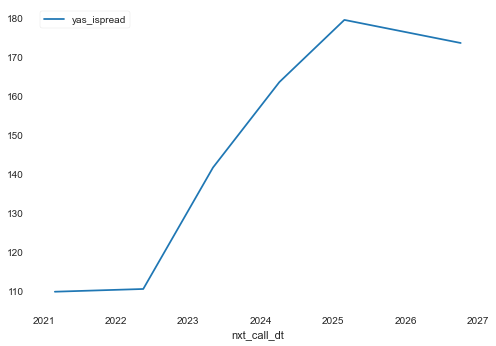

In [22]:
bond_dfsorted_byDate.plot(x='nxt_call_dt', y='yas_ispread')

### merge the historic data to the current data


In [23]:
# merge table

def mergeDataFramesWithHistorySeries_bond_df(df1, df2):
    ''' 
    function to merge dataframes
        
    inputs: 
        df1: first dataframe
        df2: second dataframe

    outputs:
        dfOut: output DataFrame

    '''
    

    # Cannot merge a Series without a name => df2 needs to have a name  (solved with rename())
    # ValueError: cannot join with no overlapping index names (solved with droplevel())
    
    #dfOut = df1.merge(df2.rename('mean_2y'),left_index=True, right_index=True)
    dfOut = df1.merge(df2,left_index=True, right_index=True)
    # print('\n\noutput dataframe:')
    
    # print(dfOut)

    return dfOut


# run function (MultiLevel series renamed and dropped to single level)
bond_df_merged = mergeDataFramesWithHistorySeries_bond_df(bond_dfsorted_byDate, bond_isprd_hist.iloc[-180:-1].mean().rename('mean_1y').droplevel(level=1))
bond_df_merged = mergeDataFramesWithHistorySeries_bond_df(bond_df_merged, bond_isprd_hist.mean().rename('mean_2y').droplevel(level=1))
bond_df_merged = mergeDataFramesWithHistorySeries_bond_df(bond_df_merged, bond_isprd_hist.std().rename('std_2y').droplevel(level=1))
bond_df_merged = mergeDataFramesWithHistorySeries_bond_df(bond_df_merged, bond_isprd_hist.min().rename('min_2y').droplevel(level=1))
bond_df_merged = mergeDataFramesWithHistorySeries_bond_df(bond_df_merged, bond_isprd_hist.max().rename('max_2y').droplevel(level=1))

# additional stats to add
bond_dfmean = bond_isprd_hist.ewm(halflife=0.25).mean().tail(1).transpose().reset_index().set_index('level_0')
bond_dfstd =  bond_isprd_hist.ewm(halflife=0.25).std().tail(1).transpose().reset_index().set_index('level_0')
#bond_dfstd = pd.ewm(bond_isprd_hist,halflife=0.5).std().tail(1).transpose().reset_index().set_index('level_0')

del bond_dfmean['level_1']
del bond_dfstd['level_1']
bond_dfmean.columns.values[-1] = 'ewm'
bond_dfstd.columns.values[-1] = 'ewmstd'

bond_df_merged = mergeDataFramesWithHistorySeries_bond_df(bond_df_merged, bond_dfmean)
bond_df_merged = mergeDataFramesWithHistorySeries_bond_df(bond_df_merged, bond_dfstd)


bond_df_merged




id_isin ticker coupon nxt_call_dt    mty_typ   px_mid  \
XS1195201931 Corp  XS1195201931  TOTAL   2.25  2021-02-26  PERP/CALL  100.786   
XS1413581205 Corp  XS1413581205  TOTAL  3.875  2022-05-18  PERP/CALL  105.454   
XS1501167164 Corp  XS1501167164  TOTAL  2.708  2023-05-05  PERP/CALL  104.502   
XS1974787480 Corp  XS1974787480  TOTAL   1.75  2024-04-04  PERP/CALL  101.791   
XS1195202822 Corp  XS1195202822  TOTAL  2.625  2025-02-26  PERP/CALL  105.206   
XS1501166869 Corp  XS1501166869  TOTAL  3.369  2026-10-06  PERP/CALL  111.355   

                  z_sprd_mid yas_ispread yas_bond_yld  yas_risk  ...  \
XS1195201931 Corp     110.58     109.817     0.655782  0.505156  ...   
XS1413581205 Corp    110.628     110.517     0.674437   1.78243  ...   
XS1501167164 Corp    141.772     141.669     0.999179    2.7211  ...   
XS1974787480 Corp    163.649     163.591      1.23738   3.54248  ...   
XS1195202822 Corp    179.762     179.538      1.42087   4.47017  ...   
XS1501166869 Corp    174.259     173.616      1.41456   6.20575  ...   

                          uniqueName reset_idx value reset coupon     mean_1y  \
XS1195201931 Corp   TOTAL 2.25 -c 21         -0.3602       1.5008  170.550615   
XS1413581205 Corp  TOTAL 3.875 -c 22         -0.3602       3.4228  182.196816   
XS1501167164 Corp  TOTAL 2.708 -c 23         -0.3602       2.3898  192.866508   
XS1974787480 Corp   TOTAL 1.75 -c 24         -0.3602       1.4048  209.365983   
XS1195202822 Corp  TOTAL 2.625 -c 25         -0.3602       1.7878  218.947508   
XS1501166869 Corp  TOTAL 3.369 -c 26         -0.3602       2.9898  210.688816   

                      mean_2y     std_2y   min_2y   max_2y         ewm  \
XS1195201931 Corp  125.316004  92.987510   40.068  676.575   99.517580   
XS1413581205 Corp  143.651171  82.212087   58.424  665.659  107.857629   
XS1501167164 Corp  159.260525  70.586069   79.577  536.924  140.156179   
XS1974787480 Corp  173.711493  79.174651   93.337  540.895  162.122928   
XS1195202822 Corp  188.637794  68.410038  105.918  551.535  177.316432   
XS1501166869 Corp  194.168986  54.718685  114.118  432.698  173.204050   

                     ewmstd  
XS1195201931 Corp  1.085789  
XS1413581205 Corp  1.758087  
XS1501167164 Corp  1.536271  
XS1974787480 Corp  2.655622  
XS1195202822 Corp  2.638195  
XS1501166869 Corp  3.471211  

[6 rows x 30 columns]

### Add column to DataFrame for z-score + adjustments

In [78]:
# add column to index

# list of differences
bond_df_merged['ispread-mean-1y'] = bond_df_merged['yas_ispread'] - bond_df_merged['mean_1y']
bond_df_merged['ispread-mean'] = bond_df_merged['yas_ispread'] - bond_df_merged['mean_2y']
bond_df_merged['z-score'] = bond_df_merged['ispread-mean'] / bond_df_merged['std_2y']
bond_df_merged['z-score-EWM'] = (bond_df_merged['yas_ispread']-bond_df_merged['ewm']) / bond_df_merged['ewmstd']
bond_df_merged['percentile'] = 100*((bond_df_merged['yas_ispread'] - bond_df_merged['min_2y']) / (bond_df_merged['max_2y'] - bond_df_merged['min_2y'])) 


# column for adjusted yield curve
# reset adjustment
mrkt_assumption_resetFactor_pct = 10
RH_assumption_resetFactor_pct = 20
resetFactor = -(RH_assumption_resetFactor_pct-mrkt_assumption_resetFactor_pct) / 100 # mrkt assumption: 10%, RH assumption: 20%, 
bond_df_merged['reset Adjustment'] = (bond_df['reset coupon'] - bond_df['reset coupon'].mean()) * 100 * resetFactor
bond_df_merged['adj-isprd'] = bond_df_merged['yas_ispread'] + bond_df_merged['reset Adjustment']

# adjust considering mean
#bond_df_merged['adj-isprd'] = bond_df_merged['yas_ispread'] + (bond_df_merged['yas_ispread'] - bond_df_merged['yas_ispread'].mean()) * resetFactor

#rating adjustment
mrkt_assumption_green_bps = -5
RH_assumption_green_bps = -20
if bond_df_merged['rtg_sp'].all() == "-":
    print('rating adjustment made')
    rtgAdj = RH_assumption_green_bps - mrkt_assumption_green_bps
else:
    rtgAdj = 0

bond_df_merged['rtgAdj']=rtgAdj    
bond_df_merged['adj-isprd'] = bond_df_merged['adj-isprd'] + rtgAdj

# SP rating adjust
# need to add this.

# fair value based on spread history to benchmark
benchmarkBond_isin = benchmark_bond_isin
benchmarkBond= benchmarkBond_isin + ' Corp'
bond_df_merged['RH fVal Av adj'] = bond_df_merged['mean_1y']-bond_df_merged.loc[benchmarkBond,'mean_1y']
bond_df_merged['RH fVal'] = bond_df_merged.loc[benchmarkBond,'adj-isprd'] + bond_df_merged['RH fVal Av adj']
print('selected benchmark bond:',bond_df.loc[benchmarkBond, 'uniqueName'])
print('1 year iSpread average for benchmark bond',bond_df_merged.loc[benchmarkBond,'mean_1y'])
    
#bond_df_merged[['security_name','mean_2y','ispread-mean','yas_ispread','ewm','std_2y','z-score','z-score-EWM']]
#bond_df_merged=bond_df_merged.drop('resetAdjust', axis=1)

bond_df_merged



selected benchmark bond: TOTAL 2.625 -c 25
1 year iSpread average for benchmark bond 218.94750837988823


id_isin ticker coupon nxt_call_dt    mty_typ px_mid  \
XS1195201931 Corp  XS1195201931  TOTAL      2  2021-02-26  PERP/CALL  1e+02   
XS1413581205 Corp  XS1413581205  TOTAL      4  2022-05-18  PERP/CALL  1e+02   
XS1501167164 Corp  XS1501167164  TOTAL      3  2023-05-05  PERP/CALL  1e+02   
XS1974787480 Corp  XS1974787480  TOTAL      2  2024-04-04  PERP/CALL  1e+02   
XS1195202822 Corp  XS1195202822  TOTAL      3  2025-02-26  PERP/CALL  1e+02   
XS1501166869 Corp  XS1501166869  TOTAL      3  2026-10-06  PERP/CALL  1e+02   

                  z_sprd_mid yas_ispread yas_bond_yld yas_risk  ...  \
XS1195201931 Corp      1e+02       1e+02          0.7      0.5  ...   
XS1413581205 Corp      1e+02       1e+02          0.7        2  ...   
XS1501167164 Corp      1e+02       1e+02            1        3  ...   
XS1974787480 Corp      2e+02       2e+02            1        4  ...   
XS1195202822 Corp      2e+02       2e+02            1        4  ...   
XS1501166869 Corp      2e+02       2e+02            1        6  ...   

                  ispread-mean-1y ispread-mean z-score z-score-EWM percentile  \
XS1195201931 Corp          -6e+01       -2e+01    -0.2           9      1e+01   
XS1413581205 Corp          -7e+01       -3e+01    -0.4           2          9   
XS1501167164 Corp          -5e+01       -2e+01    -0.2           1      1e+01   
XS1974787480 Corp          -5e+01       -1e+01    -0.1         0.6      2e+01   
XS1195202822 Corp          -4e+01           -9    -0.1         0.8      2e+01   
XS1501166869 Corp          -4e+01       -2e+01    -0.4         0.1      2e+01   

                  reset Adjustment adj-isprd rtgAdj RH fVal Av adj RH fVal  
XS1195201931 Corp                7     1e+02      0          -48.4   135.8  
XS1413581205 Corp           -1e+01     1e+02      0          -36.8   147.4  
XS1501167164 Corp               -1     1e+02      0          -26.1   158.1  
XS1974787480 Corp                8     2e+02      0           -9.6   174.6  
XS1195202822 Corp                5     2e+02      0            0.0   184.2  
XS1501166869 Corp               -7     2e+02      0           -8.3   175.9  

[6 rows x 40 columns]

In [25]:
# works better for historical data
bond_df_merged.describe()


reset_idx value     mean_1y     mean_2y     std_2y      min_2y  \
count           6.0000    6.000000    6.000000   6.000000    6.000000   
mean           -0.3602  197.436041  164.124329  74.681507   81.907000   
std             0.0000   18.743765   26.624793  13.165302   28.467889   
min            -0.3602  170.550615  125.316004  54.718685   40.068000   
25%            -0.3602  184.864239  147.553509  68.954046   63.712250   
50%            -0.3602  201.116246  166.486009  74.880360   86.457000   
75%            -0.3602  210.358108  184.906219  81.452728  102.772750   
max            -0.3602  218.947508  194.168986  92.987510  114.118000   

          max_2y         ewm    ewmstd  rtgAdj  RH fVal Av adj     RH fVal  
count    6.00000    6.000000  6.000000     6.0        6.000000    6.000000  
mean   567.38100  143.362466  2.190862     0.0      -21.511467  162.641299  
std     91.21583   33.432304  0.882312     0.0       18.743765   18.743765  
min    432.69800   99.517580  1.085789     0.0      -48.396894  135.755872  
25%    537.91675  115.932266  1.591725     0.0      -34.083270  150.069497  
50%    546.21500  151.139554  2.198141     0.0      -17.831263  166.321504  
75%    637.12800  170.433769  2.651265     0.0       -8.589401  175.563365  
max    676.57500  177.316432  3.471211     0.0        0.000000  184.152766

In [26]:
# set precission for table
pd.set_option('precision', 1)

# prepare dataframe for chart output
chartDF = pd.DataFrame(bond_df_merged)
#chartDF = chartDF.drop(columns=['ticker','cpn','nxt_call_dt','security_name','name', 'rtg_moody','rtg_sp'], axis=1)

chartDF = chartDF.reset_index(drop=True)
chartDF = chartDF[['id_isin','uniqueName','mean_2y','std_2y','min_2y','max_2y','yas_ispread','ispread-mean','z-score',
                   'percentile','reset Adjustment','adj-isprd', 'RH fVal Av adj', 'RH fVal']]
chartDF = chartDF.round({'mean_2y': 0, 'std_2y': 0, 'min_2y':0,'max_2y':0,'ewm':0,'yas_ispread':1,'ispread-mean':0,'adj-isprd':0})
chartDF['yas_ispread'] = chartDF['yas_ispread'].astype(float).round(0)
chartDF['ispread-mean'] = chartDF['ispread-mean'].astype(float).round(0)
chartDF['z-score'] = chartDF['z-score'].astype(float).round(1)
chartDF['percentile'] = chartDF['percentile'].astype(float).round(3)
chartDF['adj-isprd'] = chartDF['adj-isprd'].astype(float).round(0)
chartDF['reset Adjustment'] = chartDF['reset Adjustment'].astype(float).round(0)
chartDF['RH fVal Av adj'] = chartDF['RH fVal Av adj'].astype(float).round(0)
chartDF['RH fVal'] = chartDF['RH fVal'].astype(float).round(0)


#print(len(chartDF.columns))
print('DF shape:',chartDF.shape)
chartDF



# some nice colours example
chartDF_styled = (chartDF.style
     .highlight_min('mean_2y', color='lightyellow')
     .highlight_max('mean_2y', color='lightyellow')
     .highlight_min('std_2y', color='lightgreen')
     .highlight_max('std_2y', color='red')
     .background_gradient(subset='yas_ispread', cmap='Blues')
     .background_gradient(subset='z-score', cmap='PiYG')
     .bar('RH fVal Av adj', color='lightblue', align='zero')
     .set_caption('stats for the current ' + bond_df_merged['ticker'].iloc[0] + ' curve')
           
#      .to_excel('test.xlsx')
#      .background_gradient(subset='percentile', cmap='bwr')

        )

# convert styled object to HTML
html = chartDF_styled.render()

# time stamp & save file
ts = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
fileToSave = 'bond_df curve dataFrame ' + ts + '.png'
fileToSave = os.path.join(os.path.abspath(''), 'dataFolder', 'charts', fileToSave)

# export to HTML
#chartDF.to_html(fileToSaveHTML) # raw data only: drops formatting

# convert to PNG
# imgkit.from_string(html, 'fileToSave')

print('the file is saved here:')
print(fileToSave)

chartDF_styled




DF shape: (6, 14)
the file is saved here:
C:\Users\darren\OneDrive - Redhedge\code\bbg\corpHybrids\dataFolder\charts\bond_df curve dataFrame 2020-08-26 16_55_19.png


### replicate hybrids curve page 1 as closely as possible

In [27]:
# set precission for table
pd.set_option('precision', 1)

# note cannot copy a styled DF which is a 'Styler' object and has no attribute 'copy'

# create copy of chart DF
hc_DF = bond_df_merged.copy()


# #chartDF = chartDF.drop(columns=['ticker','cpn','nxt_call_dt','security_name','name', 'rtg_moody','rtg_sp'], axis=1)

hc_DF = hc_DF.reset_index(drop=True)
hc_DF = hc_DF[['id_isin','uniqueName','yas_ispread','mean_2y','std_2y','min_2y','max_2y','ispread-mean','z-score',
                    'percentile','reset Adjustment','adj-isprd', 'RH fVal Av adj', 'RH fVal','nxt_call_dt']]

# rename unique name to long ticker
hc_DF = hc_DF.rename(columns={'uniqueName':'long ticker'})

# reverse order (longest bond at the top)
hc_DF = hc_DF.iloc[::-1]

# add column for benchmark (called short ticker)
hc_DF['short ticker'] = bond_df_merged.loc[benchmarkBond, 'uniqueName']

# move column
hc_DF = hc_DF[['id_isin','long ticker','short ticker','yas_ispread','mean_2y','std_2y','min_2y','max_2y','ispread-mean','z-score',
                    'percentile','reset Adjustment','adj-isprd', 'RH fVal Av adj', 'RH fVal','nxt_call_dt']]

# rename column
hc_DF = hc_DF.rename(columns={'yas_ispread':'long spread'})

# format column to zero dp
hc_DF['long spread'] = hc_DF['long spread'].map('{:,.0f}'.format)

# add column for short spread
hc_DF['short spread'] = bond_df_merged.loc[benchmarkBond,'yas_ispread']

# move column
hc_DF = hc_DF[['id_isin','long ticker','short ticker','long spread','short spread','mean_2y','std_2y','min_2y','max_2y','ispread-mean','z-score',
                    'percentile','reset Adjustment','adj-isprd', 'RH fVal Av adj', 'RH fVal','nxt_call_dt']]

# format column to zero dp
hc_DF['short spread'] = hc_DF['short spread'].map('{:,.0f}'.format)

# add column for basis
hc_DF['basis'] = hc_DF['long spread'].astype(int) - hc_DF['short spread'].astype(int)

# move column
hc_DF = hc_DF[['id_isin','long ticker','short ticker','long spread','short spread','basis','mean_2y','std_2y','min_2y','max_2y','ispread-mean','z-score',
                    'percentile','reset Adjustment','adj-isprd', 'RH fVal Av adj', 'RH fVal','nxt_call_dt']]


# add column for years
hc_DF['yrs'] = ((hc_DF['nxt_call_dt'] - bond_df_merged.loc[benchmarkBond,'nxt_call_dt'])/np.timedelta64(1,'D'))/365

# format column to 1dp
hc_DF['yrs'] = hc_DF['yrs'].map('{:,.1f}'.format)

# move column
hc_DF = hc_DF[['id_isin','long ticker','short ticker','long spread','short spread','basis','yrs','mean_2y','std_2y','min_2y','max_2y','ispread-mean','z-score',
                    'percentile','reset Adjustment','adj-isprd', 'RH fVal Av adj', 'RH fVal','nxt_call_dt']]

# add column for curve per year
hc_DF['curve per yr'] = (hc_DF['basis'] / hc_DF['yrs'].astype(float))#.map('${:,1f}'.format)

# format column to zero dp
#hc_DF['curve per yr'] = hc_DF['curve per yr'].astype(np.int64)

# move column
hc_DF = hc_DF[['id_isin','long ticker','short ticker','long spread','short spread','basis','yrs','curve per yr','mean_2y','std_2y','min_2y','max_2y','ispread-mean','z-score',
                    'percentile','reset Adjustment','adj-isprd', 'RH fVal Av adj', 'RH fVal','nxt_call_dt']]


# add column for curve change 14d
# bond spread 14 d ago
bond_isprd_hist_reverse = bond_isprd_hist.copy() #make a copy
bond_isprd_hist_reverse = bond_isprd_hist_reverse.iloc[::-1] # execute reverse
x = bond_isprd_hist_reverse.iloc[10].droplevel(level=1) # 14 cal days ~ 10 busns days
hc_DF['sprd 14d ago'] = [x.loc[i + ' Corp'] for i in hc_DF['id_isin']]

# bmk spread 14 d ago
bmk_14d_ago = x.loc[benchmarkBond]
print('the benchmark 14 day ago was', bmk_14d_ago)
print('the benchmark today is', bond_isprd_hist_reverse.iloc[0].droplevel(level=1).loc[benchmarkBond])

# bond - benchmark 14 days ago
hc_DF['bond-bench 14d ago'] = hc_DF['sprd 14d ago'] - bmk_14d_ago

# the curve per year 14 d ago
hc_DF['curve per yr 14d ago'] = hc_DF['bond-bench 14d ago'] / hc_DF['yrs'].astype(float)

# change in curve over 14d = hc_DF['curve per yr'] - curve 14 days ago
hc_DF['curve shift over 14d'] = hc_DF['curve per yr']  - hc_DF['curve per yr 14d ago'] 
hc_DF['curve chng 14d'] = hc_DF['curve shift over 14d']

# add column for curve change 30d
x = bond_isprd_hist_reverse.iloc[22].droplevel(level=1) # 30 cal days ~ 22 busns days
hc_DF['sprd 30d ago'] = [x.loc[i + ' Corp'] for i in hc_DF['id_isin']]



# rename column
hc_DF = hc_DF.rename(columns={'mean_2y':'av','min_2y':'min','max_2y':'max','std_2y':'std'})  #, 'z-score':'z'

# move column
hc_DF = hc_DF[['id_isin','long ticker','short ticker','long spread','short spread','basis','yrs','curve per yr',
               'curve chng 14d','min','av','max','std','z-score',
                    'percentile','sprd 14d ago','curve per yr 14d ago', 'curve shift over 14d']]


# rename column
hc_DF = hc_DF.rename(columns={'z-score':'z','percentile':'%-ile'})


# when complete convert to a style object
hc_DF = (hc_DF.style
     .background_gradient(subset='curve per yr', cmap='Reds')
     .bar('curve chng 14d', color=('pink','lightblue'), align='zero')
     .bar(subset='z', color=('orange','blue'), align='zero')
     .set_caption(corporate_ticker+' curve to benchmark')
     .set_table_styles([{'selector': 'th', 'props': [('font-size', '10pt'),('font-name','Courier New')]}])
     .set_properties(**{'font-size': '8pt','font-name':'Courier New'})
        )


display(hc_DF)

# write to html
html = hc_DF.render()
with open(os.path.join(dir_path, 'dataFolder','htmlData', corporate_ticker+' curve to benchmark.html'), "w") as file:
    file.write(html)

    
    

the benchmark 14 day ago was 183.458
the benchmark today is 177.086


### plot the new data

In [28]:
# colours / conditional formatting


# createDF of same size with zero's
coloursDF = chartDF.replace(chartDF,0)
coloursDF.loc[:,:]='white'
#coloursDF.loc[:,'percentile']='red'
coloursDF['percentile']= chartDF['percentile']
coloursDF.loc[chartDF['percentile'] > 75, 'percentile'] = 'orange'
coloursDF.loc[chartDF['percentile'] < 75, 'percentile'] = 'white'
coloursDF.loc[chartDF['percentile'] < 25, 'percentile'] = 'lightcyan'


coloursDF.loc[(chartDF['adj-isprd']-chartDF['yas_ispread']) > 10, 'adj-isprd'] = 'green'
coloursDF.loc[(chartDF['adj-isprd']-chartDF['yas_ispread']) < -10, 'adj-isprd'] = 'red'

coloursDF.loc[chartDF['z-score'] < -1, 'z-score'] = 'orange'
coloursDF.loc[chartDF['z-score'] < -2, 'z-score'] = 'red'
coloursDF.loc[chartDF['z-score'] > 1, 'z-score'] = 'green'
coloursDF.loc[chartDF['z-score'] > 2, 'z-score'] = 'blue'

coloursDF.loc[chartDF['std_2y'] == chartDF['std_2y'].values.min(), 'std_2y'] = 'skyblue'
coloursDF.loc[chartDF['std_2y'] == chartDF['std_2y'].values.max(), 'std_2y'] = 'pink'

#using .apply
def adjustmentColour(n):
    """ take a value, return a colour"""
    if n<-100:
        c = 'darksalmon'
    elif n<-50:
        c = 'salmon'
    elif n<-25:
        c = 'lightsalmon'
    elif n<25:
        c='white'
    elif n<50:
        c='palegreen'
    elif n<100:
        c='lightgreen'
    else:
        c='limegreen'
    return c

coloursDF['RH fVal Av adj'] = chartDF['RH fVal Av adj'].apply(adjustmentColour)

print('shape: ',coloursDF.shape)
coloursDF

#pd.DataFrame(index=range(numRows),columns=range(numCols))

shape:  (6, 14)


id_isin uniqueName mean_2y   std_2y min_2y max_2y yas_ispread ispread-mean  \
0   white      white   white     pink  white  white       white        white   
1   white      white   white    white  white  white       white        white   
2   white      white   white    white  white  white       white        white   
3   white      white   white    white  white  white       white        white   
4   white      white   white    white  white  white       white        white   
5   white      white   white  skyblue  white  white       white        white   

  z-score percentile reset Adjustment adj-isprd RH fVal Av adj RH fVal  
0   white  lightcyan            white     white    lightsalmon   white  
1   white  lightcyan            white       red    lightsalmon   white  
2   white  lightcyan            white     white    lightsalmon   white  
3   white  lightcyan            white     white          white   white  
4   white  lightcyan            white     white          white   white  
5   white  lightcyan            white     white          white   white

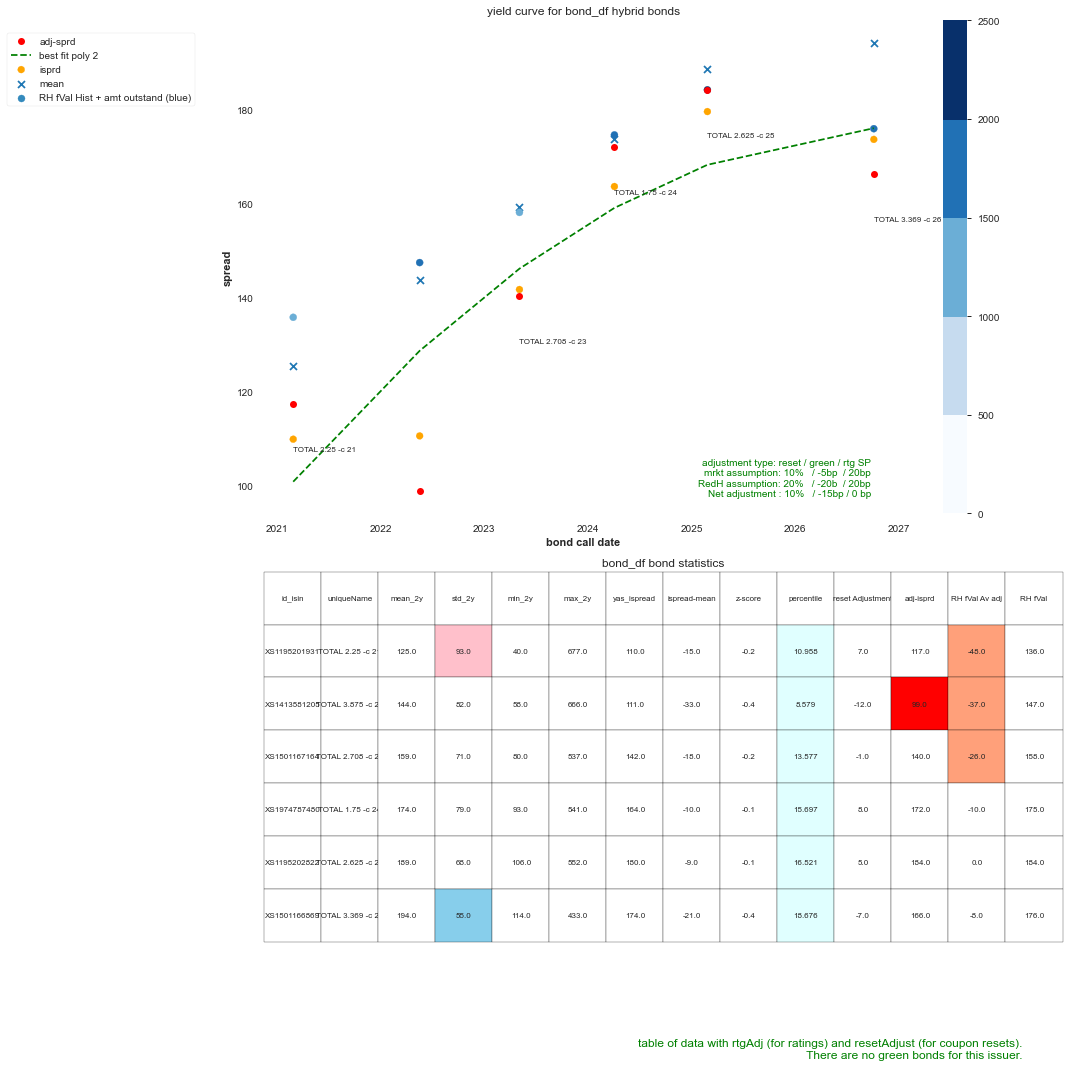

the file is saved here:
C:\Users\darren\OneDrive - Redhedge\code\bbg\corpHybrids\dataFolder\pdfData\adjusted yld curve 2020-08-26 17_04_26.pdf


In [76]:
fig, ax = plt.subplots(2,1, figsize=(15,15), tight_layout=True)

cmap = mpl.cm.get_cmap('Blues',5)

ax[0].scatter(x=bond_df_merged['nxt_call_dt'], y=bond_df_merged['yas_ispread'], marker='o', label='isprd', ls='-.', color='orange')
ax[0].plot(bond_df_merged['nxt_call_dt'], bond_df_merged['adj-isprd'], marker='o', label='adj-sprd',  linestyle='', color='red')
ax[0].scatter(x=bond_df_merged['nxt_call_dt'], y=bond_df_merged['mean_2y'], marker='x', label = 'mean')
#ax[0].scatter(x=bond_df_merged['nxt_call_dt'], y=bond_df_merged['ewm'], marker='x', label = 'exp mean', color = 'pink')
cax = ax[0].scatter(x=bond_df_merged['nxt_call_dt'], y=bond_df_merged['RH fVal'], marker='o', s=50,
              label = 'RH fVal Hist + amt outstand (blue)', 
                    c=bond_df_merged['amt_outstanding']/1000000, cmap=cmap, 
                    vmin=0,  alpha=1) #vmax=2000, no need as vmax self calibrates

fig.colorbar(cax, ax=ax[0])


# ax[0].set_label('Color Intensity')

ax[0].xaxis.set_label_text('bond call date', weight='bold')
ax[0].yaxis.set_label_text('spread', weight='bold')
ax[0].title.set_text('yield curve for bond_df hybrid bonds')

# colours


# plot a table
#pd.plotting.table(ax[1],chartDF,loc='center', colWidths=[0.1]*2 + [0.05]*(len(chartDF.columns)-2)).set_fontsize('large')
#ax[1].table(cellText=chartDF.values, colLabels=chartDF.columns, bbox=[0,0.25,1,0.75],cellLoc='center')#.auto_set_font_size(False)
the_table = ax[1].table(cellText=chartDF.values, colLabels=chartDF.columns, bbox=[0,0.25,1,0.75],
                        cellLoc='center',cellColours=coloursDF.values)
the_table.auto_set_font_size(False)
the_table.set_fontsize(8)
the_table.scale(1, 1)
ax[1].title.set_text('example dataframe with plot')
ax[1].axis('off')


# label the points
for i, txt in enumerate(bond_df_merged['uniqueName'].values):
    n = 10
    if i == 6:
        n=20    
    if i == 7:
        n=30
    if i == 8:
        n=40
    if i==9:
        n=60
    if i==10:
        n=70
    ax[0].annotate(txt, (bond_df_merged['nxt_call_dt'][i], bond_df_merged['adj-isprd'][i]-n), fontsize=8)

# adjustments comment
adjComment =               'adjustment type: reset / green / rtg SP\n'
adjComment =  adjComment + f'mrkt assumption: {mrkt_assumption_resetFactor_pct}%   / {mrkt_assumption_green_bps}bp  / 20bp\n'
adjComment =  adjComment + f'RedH assumption: {RH_assumption_resetFactor_pct}%   / {RH_assumption_green_bps}b  / 20bp\n'
adjComment =  adjComment + f'Net adjustment : {(RH_assumption_resetFactor_pct-mrkt_assumption_resetFactor_pct)}%   / {RH_assumption_green_bps-mrkt_assumption_green_bps}bp / 0 bp\n'
    
# anotate the chart
ax[0].text(0.95, 0.01, adjComment,
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax[0].transAxes,
        color='green', fontsize=10)



# anotate the table
ax[1].text(0.95, 0.01, 'table of data with rtgAdj (for ratings) and resetAdjust (for coupon resets).\n There are no green bonds for this issuer.',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax[1].transAxes,
        color='green', fontsize=12)


# add RH fair value curve


# line of best fit
# first convert datetime to numbers
#dateIntegers = [int (i.strftime('%Y%m%d')) for i in bond_df_merged['nxt_call_dt'].values]
dateIntegers = pd.to_datetime(bond_df_merged['nxt_call_dt']).values.astype(float)


y = bond_df_merged['adj-isprd'].values.tolist()
bestFit = np.polyfit(dateIntegers, bond_df_merged['adj-isprd'].values.tolist(), 2)

p = np.poly1d(bestFit)
ax[0].plot(bond_df_merged['nxt_call_dt'],p(dateIntegers),  linestyle='--', color='green', label='best fit poly 2')

ax[0].legend(loc='center right', bbox_to_anchor=(-0.1, 0.9))
plt.title('bond_df bond statistics')
plt.show()


# time stamp & save file
ts = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
fileToSave = 'adjusted yld curve ' + ts + '.pdf'
fileToSave = os.path.join(os.path.abspath(''), 'dataFolder', 'pdfData', fileToSave)


fig.tight_layout()
fig.savefig(fileToSave)
print('the file is saved here:')
print(fileToSave)


In [30]:
bond_df_merged.to_excel(os.path.join(os.path.abspath(''),'dataFolder','xlsxData','bond_df_merged.xlsx'))
bond_df_merged

id_isin ticker coupon nxt_call_dt    mty_typ px_mid  \
XS1195201931 Corp  XS1195201931  TOTAL      2  2021-02-26  PERP/CALL  1e+02   
XS1413581205 Corp  XS1413581205  TOTAL      4  2022-05-18  PERP/CALL  1e+02   
XS1501167164 Corp  XS1501167164  TOTAL      3  2023-05-05  PERP/CALL  1e+02   
XS1974787480 Corp  XS1974787480  TOTAL      2  2024-04-04  PERP/CALL  1e+02   
XS1195202822 Corp  XS1195202822  TOTAL      3  2025-02-26  PERP/CALL  1e+02   
XS1501166869 Corp  XS1501166869  TOTAL      3  2026-10-06  PERP/CALL  1e+02   

                  z_sprd_mid yas_ispread yas_bond_yld yas_risk  ...  \
XS1195201931 Corp      1e+02       1e+02          0.7      0.5  ...   
XS1413581205 Corp      1e+02       1e+02          0.7        2  ...   
XS1501167164 Corp      1e+02       1e+02            1        3  ...   
XS1974787480 Corp      2e+02       2e+02            1        4  ...   
XS1195202822 Corp      2e+02       2e+02            1        4  ...   
XS1501166869 Corp      2e+02       2e+02            1        6  ...   

                  ispread-mean-1y ispread-mean z-score z-score-EWM percentile  \
XS1195201931 Corp          -6e+01       -2e+01    -0.2           9      1e+01   
XS1413581205 Corp          -7e+01       -3e+01    -0.4           2          9   
XS1501167164 Corp          -5e+01       -2e+01    -0.2           1      1e+01   
XS1974787480 Corp          -5e+01       -1e+01    -0.1         0.6      2e+01   
XS1195202822 Corp          -4e+01           -9    -0.1         0.8      2e+01   
XS1501166869 Corp          -4e+01       -2e+01    -0.4         0.1      2e+01   

                  reset Adjustment adj-isprd rtgAdj RH fVal Av adj RH fVal  
XS1195201931 Corp                7     1e+02      0          -48.4   135.8  
XS1413581205 Corp           -1e+01     1e+02      0          -36.8   147.4  
XS1501167164 Corp               -1     1e+02      0          -26.1   158.1  
XS1974787480 Corp                8     2e+02      0           -9.6   174.6  
XS1195202822 Corp                5     2e+02      0            0.0   184.2  
XS1501166869 Corp               -7     2e+02      0           -8.3   175.9  

[6 rows x 40 columns]

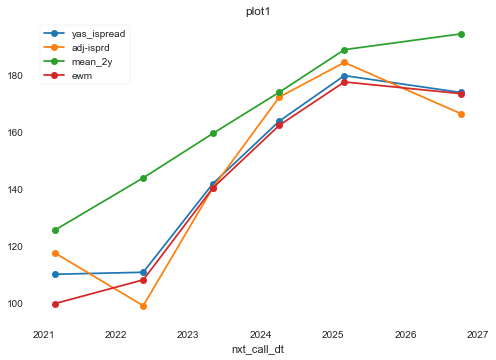

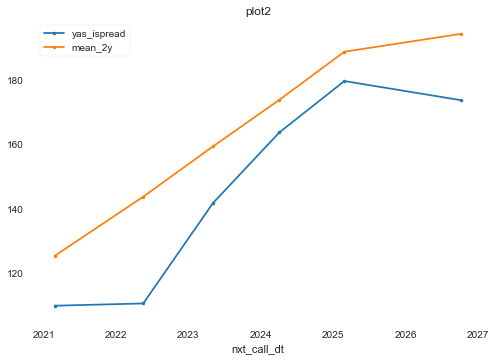

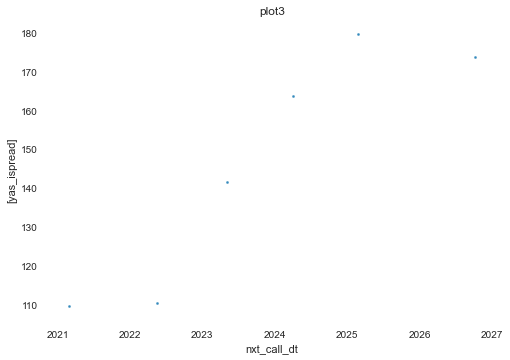

In [31]:
# plot data
bond_df_merged.plot(x='nxt_call_dt', y=['yas_ispread', 'adj-isprd','mean_2y', 'ewm'], marker='o', title="plot1")
bond_df_merged.plot(x='nxt_call_dt', y=['yas_ispread','mean_2y'], marker='.', title="plot2")
bond_df_merged.plot(x='nxt_call_dt', y=['yas_ispread'], kind='scatter', marker='.', title="plot3")
plt.show()


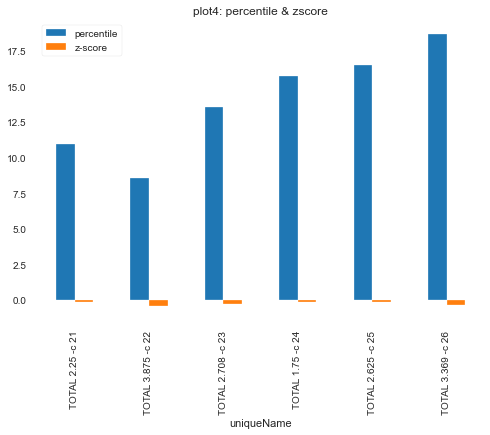

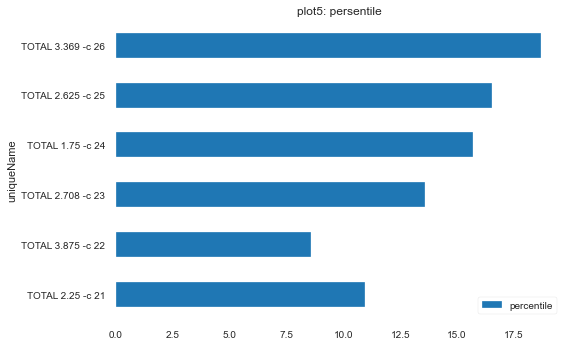

In [32]:
bond_df_merged.plot(x='uniqueName', y=['percentile', 'z-score'] ,kind='bar', title="plot4: percentile & zscore")
bond_df_merged.plot(x='uniqueName', y='percentile' ,kind='barh', title="plot5: persentile")
plt.show()

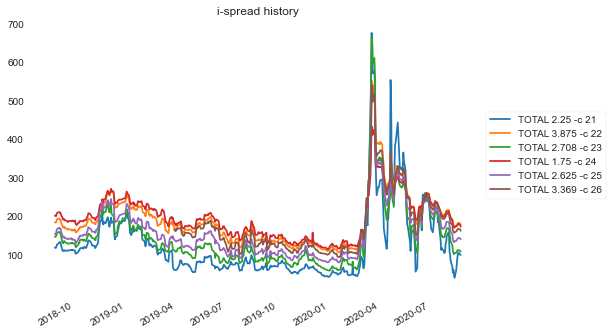

In [33]:
# Plot history with correct labels


ax = bond_isprd_hist.plot()
# list of bonds
#print(bond_df_merged[['id_isin','security_name']])

# prepare legend list
legendList = []
for i in isin_list:
    counter = 0
    for j in bond_df_merged['id_isin']:
        if j == i:
            #print(i, j, bond_df_merged['security_name'][counter], counter)
            legendList.append(bond_df_merged['uniqueName'][counter])  #security_name

        counter = counter + 1

# print(legendList)


# ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.legend(legendList, loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_title('i-spread history')
ax


### box and whisker plot

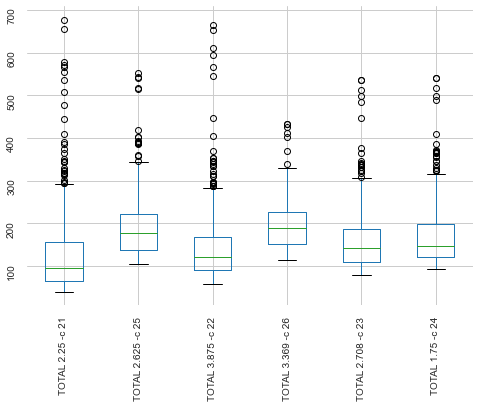

In [34]:
#df = pd.DataFrame(bond_isprd_hist[('XS1206541366 Corp', 'blp_i_sprd_mid')].values, columns=['this'])
#df['that']=bond_isprd_hist[('XS1799939027 Corp', 'blp_i_sprd_mid')].values
df = pd.DataFrame(bond_isprd_hist[bond_isprd_hist.columns].values, columns=bond_df['uniqueName'].values)
df



boxplot = df.boxplot(column=bond_df['uniqueName'].values.tolist()).tick_params(labelrotation=90)

### subplots

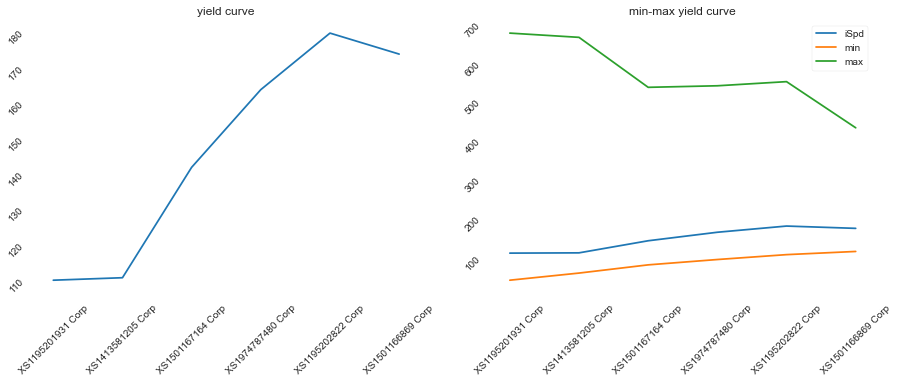

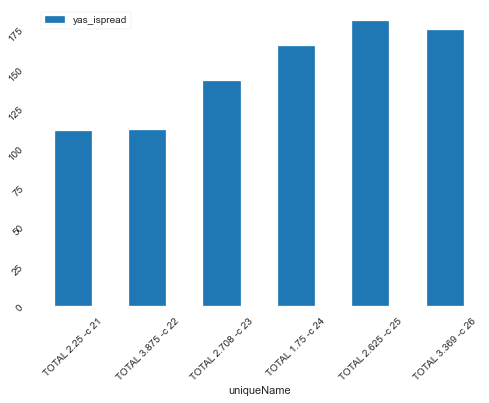

In [35]:
figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5) )

bond_df_merged['yas_ispread'].plot(ax=axes[0])
bond_df_merged['yas_ispread'].plot(ax=axes[1])
bond_df_merged['min_2y'].plot(ax=axes[1])
bond_df_merged['max_2y'].plot(ax=axes[1])

axes[0].set_title('yield curve')
axes[0].tick_params(labelrotation=45)
axes[1].legend(['iSpd','min','max'])
axes[1].set_title('min-max yield curve')
axes[1].tick_params(labelrotation=45)

bond_df_merged[['uniqueName', 'yas_ispread']].plot(x='uniqueName', y='yas_ispread', kind='bar').tick_params(labelrotation=45)



# Spread to Benchmark History
Define a benchmark bond and get the spread to benchmark history for all other bonds in the list.

In [36]:
def spreadToBenchmarkHistory(isinBench: str, isin_list: list):
    """
    define a benchmark bond and get spread to benchmark hiistory for bonds in hthe list.
    
        input:
            isinBench: the benchmark isin
            isin_list: the benchmark isins list
            
        output:
            df: dataframe containing benchmark histories
            
    """
    
    # remove benchmark from list
    if isinBench in isin_list:
        print('isin removed')
        isin_list.remove(isinBench)
    else:
        print('isin not in bench')
    

    # list of isins
    isin_list_corp = [i + ' Corp' for i in isin_list]
    print('here is the list: ', isin_list)
    

    # fields
    fieldList = 'blp_i_sprd_mid'

    # start and end dates to use
    dateToUseToday = datetime.date.today()
    dateToUse2yAgo = dateToUseToday + datetime.timedelta(days=-365*2)
    
    print('lets go between today and 2 years ago')
    print('today:', dateToUseToday)
    print('2y ago:', dateToUse2yAgo)



    # request from bbg returning a MultiIndex DataFrame object - for the isin list    
    bondDataHist = blp.bdh(
        tickers= isin_list_corp, flds=fieldList,
        start_date=dateToUse2yAgo, end_date=dateToUseToday,
        )

    # request from bbg returning a MultiIndex DataFrame object - for the isin benchmark  
    benchDataHist = blp.bdh(
        tickers= isinBench+ ' Corp', flds=fieldList,
        start_date=dateToUse2yAgo, end_date=dateToUseToday,
        )

    # MultiIndex dataframe for spreads
    spreadDataHist = bondDataHist.sub(benchDataHist[(isinBench+ ' Corp', 'blp_i_sprd_mid')], axis=0)
    
    # print(spreadDataHist)
    # rename columns
    spreadDataHist.columns = isin_list
    
    
    return spreadDataHist


benchmarkBond = benchmarkBond_isin
bond_df_spd_to_bmk_hist = spreadToBenchmarkHistory(benchmarkBond_isin, listOfBonds)


#print(type(bond_df_spd_to_bmk))
#bond_df_spd_to_bmk.rename(columns={"('XS0968913342 Corp', 'blp_i_sprd_mid')": 'testBond'}, inplace=True)
bond_df_spd_to_bmk_hist





isin removed
here is the list:  ['XS1195201931', 'XS1413581205', 'XS1501167164', 'XS1974787480', 'XS1501166869']
lets go between today and 2 years ago
today: 2020-08-26
2y ago: 2018-08-27


XS1195201931  XS1413581205  XS1501167164  XS1974787480  \
2018-08-27         -65.1         -36.9          17.7         -29.6   
2018-08-28         -66.3         -37.5          17.1         -30.0   
2018-08-29         -65.2         -35.5          16.5         -29.1   
2018-08-30         -65.7         -35.5          17.0         -25.6   
2018-08-31         -66.1         -35.8          16.0         -26.1   
...                  ...           ...           ...           ...   
2020-08-19         -87.5         -68.7          -4.0         -39.2   
2020-08-20         -80.7         -71.0          -3.3         -39.4   
2020-08-21         -77.5         -71.1          -3.0         -39.3   
2020-08-24         -81.2         -70.6          -3.0         -38.6   
2020-08-25         -77.6         -69.4          -4.2         -37.1   

            XS1501166869  
2018-08-27           NaN  
2018-08-28           NaN  
2018-08-29           NaN  
2018-08-30           NaN  
2018-08-31           NaN  
...                  ...  
2020-08-19         -15.1  
2020-08-20         -15.3  
2020-08-21         -15.5  
2020-08-24         -15.1  
2020-08-25         -15.2  

[510 rows x 5 columns]

## A summary of all the time series data

In [37]:
bond_df_spd_to_bmk_hist.describe()

XS1195201931  XS1413581205  XS1501167164  XS1974787480  XS1501166869
count         510.0         510.0         510.0         510.0         359.0
mean          -63.3         -45.0           5.5         -29.4         -10.1
std            39.4          22.8          18.5          10.2           6.5
min          -151.6         -80.8        -118.8         -56.2         -34.7
25%           -78.0         -58.4           4.4         -35.8         -13.2
50%           -66.2         -47.3           9.6         -30.5         -10.1
75%           -57.5         -38.0          13.9         -24.0          -7.2
max           196.0         142.4          25.0          44.0          11.2

In [38]:
# save to csv

# time stamp & path etc.
ts = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
fileToSave = 'bond_isprd_toBMK_HistoryStats ' + ts + '.csv'
fileToSave = os.path.join(os.path.abspath(''), 'dataFolder', 'csvData', fileToSave)

# export to csv
bond_df_spd_to_bmk_hist.describe().to_csv(fileToSave)
print('CSV file saved here: ', fileToSave)


# time stamp & path etc.
ts = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
fileToSave = 'bond_isprd_toBMK_HistoryStats ' + ts + '.xlsx'
fileToSave = os.path.join(os.path.abspath(''), 'dataFolder', 'xlsxData', fileToSave)

# export to xlsx
bond_df_spd_to_bmk_hist.describe().to_excel(fileToSave)
print('XLSX file saved here: ', fileToSave)




CSV file saved here:  C:\Users\darren\OneDrive - Redhedge\code\bbg\corpHybrids\dataFolder\csvData\bond_isprd_toBMK_HistoryStats 2020-08-26 16_55_29.csv
XLSX file saved here:  C:\Users\darren\OneDrive - Redhedge\code\bbg\corpHybrids\dataFolder\xlsxData\bond_isprd_toBMK_HistoryStats 2020-08-26 16_55_29.xlsx


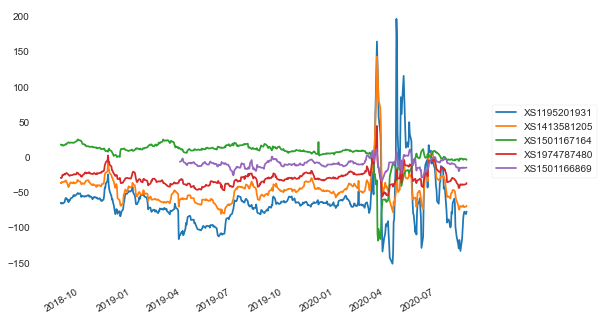

<class 'matplotlib.axes._subplots.AxesSubplot'>


In [39]:
# plot this

ax = bond_df_spd_to_bmk_hist.plot()
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
#ax.tight_layout()
plt.show()

print(type(ax))

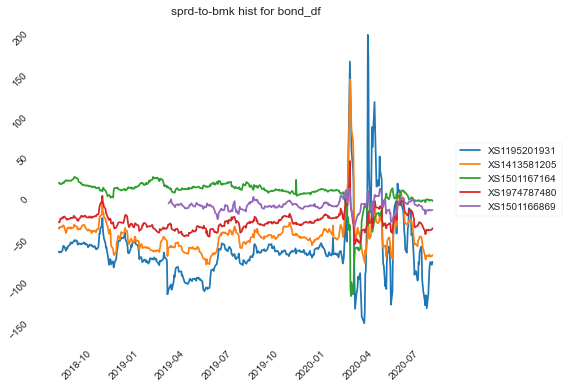

In [40]:
# method 2 for plotting
fig, ax = plt.subplots()
ax.plot(bond_df_spd_to_bmk_hist)
ax.title.set_text('sprd-to-bmk hist for bond_df')
ax.legend(bond_df_spd_to_bmk_hist.columns, loc='center left',bbox_to_anchor=(1.0, 0.5))
ax.tick_params(labelrotation=45)
fig.tight_layout()

# time stamp & save file
ts = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
fileToSave = 'spreadImage ' + ts + '.png'
fileToSave = os.path.join(os.path.abspath(''), 'dataFolder', 'charts', fileToSave)

fig.savefig(fileToSave)



In [41]:
# give columns nice names

bond_df_spread_list = [] # list to store names
for i in bond_df_spd_to_bmk_hist.columns:
    bond_df_spread_list.append(bond_df_merged.loc[bond_df_merged['id_isin'] == i, 'uniqueName'].item())
    
print(bond_df_spread_list)
# print(type(bond_df_spread_list))    
    

['TOTAL 2.25 -c 21', 'TOTAL 3.875 -c 22', 'TOTAL 2.708 -c 23', 'TOTAL 1.75 -c 24', 'TOTAL 3.369 -c 26']


### examples of histograms

##### one specific bond

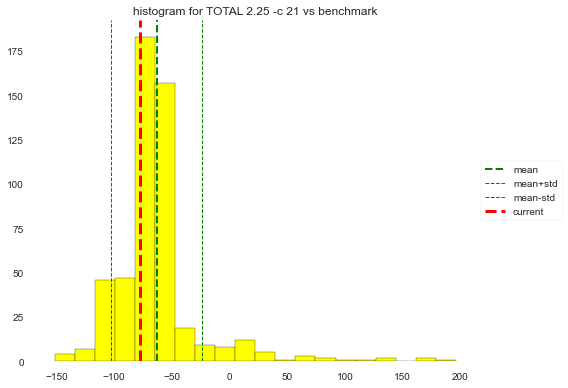

the isin number is:  XS1195201931
the mean spread is:  -63.3
the stdev spread is:  39.4
the current spread is:  -77.6
--------------------
the file is saved here:  C:\Users\darren\OneDrive - Redhedge\code\bbg\corpHybrids\dataFolder\charts\XS11952019312020-08-26 16_55_31.png


In [42]:
#print(type(bond_df_spd_to_bmk[('XS0968913342 Corp','blp_i_sprd_mid')]))
bond_to_plot = listOfBonds[0]
bond_name = bond_df_merged.loc[bond_df_merged['id_isin'] == bond_to_plot, 'uniqueName'].item()
#bond_df_spd_to_bmk_hist[(bond_to_plot)].hist(bins=20, color='yellow',edgecolor='k')
fig, ax = plt.subplots()
plt.hist(bond_df_spd_to_bmk_hist[(bond_to_plot)],bins=20, color='yellow',edgecolor='k')
plt.axvline(bond_df_spd_to_bmk_hist[(bond_to_plot)].mean(), color='green', linestyle='dashed', linewidth=2, label='mean')
plt.axvline(bond_df_spd_to_bmk_hist[(bond_to_plot)].mean()+bond_df_spd_to_bmk_hist[(bond_to_plot)].std(), color='green', linestyle='dashed', linewidth=1, label='mean+std')
plt.axvline(bond_df_spd_to_bmk_hist[(bond_to_plot)].mean()-bond_df_spd_to_bmk_hist[(bond_to_plot)].std(), color='green', linestyle='dashed', linewidth=1, label='mean-std')
plt.axvline(bond_df_spd_to_bmk_hist[(bond_to_plot)].values[-1], color='red', linestyle='dashed', linewidth=3, label='current')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=10)
plt.title(f'histogram for {bond_name} vs benchmark')
plt.tight_layout()
plt.show()

print('the isin number is: ', bond_to_plot)
print('the mean spread is: ',round(bond_df_spd_to_bmk_hist[(bond_to_plot)].mean(),1))
print('the stdev spread is: ',round(bond_df_spd_to_bmk_hist[(bond_to_plot)].std(),1))
print('the current spread is: ', round(bond_df_spd_to_bmk_hist[(bond_to_plot)].values[-1],1))
print('--------------------')


# time stamp & save file
ts = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
fileToSave = bond_to_plot + ts + '.png'
fileToSave = os.path.join(os.path.abspath(''), 'dataFolder', 'charts', fileToSave)

fig.savefig(fileToSave)
print('the file is saved here: ', fileToSave)


##### all the bonds (multi plot)

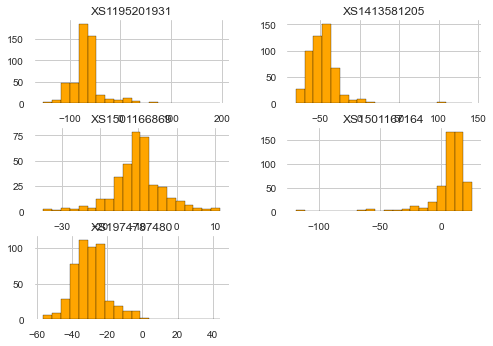

In [43]:
bond_df_spd_to_bmk_hist.hist(bins=20, color='orange',edgecolor='k')  #.subplots_adjust(hspace=0)
plt.show()

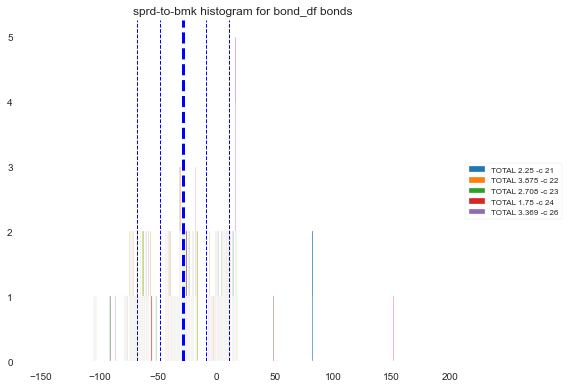

the mean is:  -28.4
the st dev is:  19.5


In [44]:

fig, ax = plt.subplots(tight_layout=True)

ax.hist(bond_df_spd_to_bmk_hist)
#ax.legend(bond_df_spd_to_bmk.columns)
ax.legend(bond_df_spread_list, loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=8)
ax.title.set_text('sprd-to-bmk histogram for bond_df bonds')

ax.axvline(bond_df_spd_to_bmk_hist.mean().mean(), color='blue', linestyle='dashed', linewidth=3, label='mean')
ax.axvline(bond_df_spd_to_bmk_hist.mean().mean()+bond_df_spd_to_bmk_hist.std().mean(), color='blue', linestyle='dashed', linewidth=1, label='mean+std')
ax.axvline(bond_df_spd_to_bmk_hist.mean().mean()-bond_df_spd_to_bmk_hist.std().mean(), color='blue', linestyle='dashed', linewidth=1, label='mean+std')
ax.axvline(bond_df_spd_to_bmk_hist.mean().mean()+2*bond_df_spd_to_bmk_hist.std().mean(), color='blue', linestyle='dashed', linewidth=1, label='mean+2*std')
ax.axvline(bond_df_spd_to_bmk_hist.mean().mean()-2*bond_df_spd_to_bmk_hist.std().mean(), color='blue', linestyle='dashed', linewidth=1, label='mean+2*std')

#fig.tight_layout()
#bond_df_spd_to_bmk.mean()

plt.show()

print('the mean is: ', round(bond_df_spd_to_bmk_hist.mean().mean(),1))
print('the st dev is: ', round(bond_df_spd_to_bmk_hist.std().mean(),1))



### some statistics

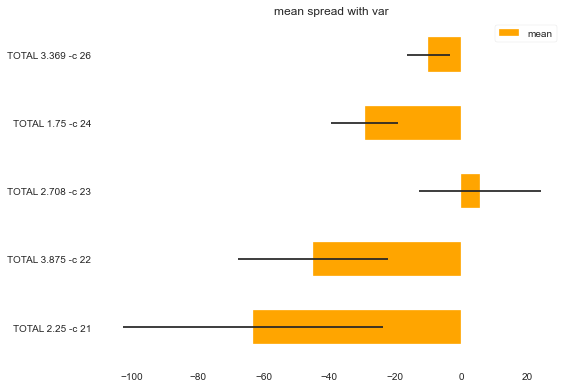

In [45]:

# print('the mean is: \n', bond_df_spd_to_bmk.mean())
# print('the standard deviation is: \n', bond_df_spd_to_bmk.std())



bond_df_spd_to_bmk_hist.mean().plot(kind='barh', label='mean', color='orange', 
                          xerr=bond_df_spd_to_bmk_hist.std(), 
                          title='mean spread with var').legend(['mean'])
# add dots for current spread
#bond_df_spd_to_bmk.mean().plot(kind='barh', label='current', color='red').legend(['current'])

plt.yticks(range(len(bond_df_spread_list)),bond_df_spread_list)

plt.tight_layout()
plt.show()


# time stamp & save file
ts = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
fileToSave = 'meanSpreads_and_Variances ' + ts + '.png'
fileToSave = os.path.join(os.path.abspath(''), 'dataFolder', 'charts', fileToSave)

fig.savefig(fileToSave)



### some z scores

In [46]:
# zscore is: (value - mean() / std())
bond_df_spd_to_bmk_df = pd.DataFrame({'bonds':bond_df_spread_list,'mean_spd_to_bmk':bond_df_spd_to_bmk_hist.mean(), 'st dev spd_to_bmk':bond_df_spd_to_bmk_hist.std()})
bond_df_spd_to_bmk_df['id_isin'] = bond_df_spd_to_bmk_df.index
#bond_df_spd_to_bmk_df.merge(bond_df_merged,how='left', right_on='id_isin')

#x = bond_df_merged['id_isin'].loc[benchmarkBond]
#print(x)
# x = bond_df.loc[benchmarkBond+" Corp", 'yas_ispread']
# print(x)

#bond_df_spd_to_bmk_df['sprd_to_bmk'] = bond_df_spd_to_bmk_df['yas_ispread']  - bond_df.loc[benchmarkBond+" Corp", 'yas_ispread']

bond_df_spd_to_bmk_df = pd.merge(bond_df_spd_to_bmk_df, bond_df_merged, on='id_isin')
bond_df_spd_to_bmk_df['sprd_to_bmk'] = bond_df_spd_to_bmk_df['yas_ispread']  - bond_df.loc[benchmarkBond+" Corp", 'yas_ispread']

bond_df_spd_to_bmk_df['z-score spd_to_bmk'] = (bond_df_spd_to_bmk_df['sprd_to_bmk']-bond_df_spd_to_bmk_df['mean_spd_to_bmk'])/bond_df_spd_to_bmk_df['st dev spd_to_bmk']
bond_df_spd_to_bmk_df
#bond_df_merged




bonds  mean_spd_to_bmk  st dev spd_to_bmk       id_isin ticker  \
0   TOTAL 2.25 -c 21            -63.3               39.4  XS1195201931  TOTAL   
1  TOTAL 3.875 -c 22            -45.0               22.8  XS1413581205  TOTAL   
2  TOTAL 2.708 -c 23              5.5               18.5  XS1501167164  TOTAL   
3   TOTAL 1.75 -c 24            -29.4               10.2  XS1974787480  TOTAL   
4  TOTAL 3.369 -c 26            -10.1                6.5  XS1501166869  TOTAL   

  coupon nxt_call_dt    mty_typ px_mid z_sprd_mid  ... z-score z-score-EWM  \
0      2  2021-02-26  PERP/CALL  1e+02      1e+02  ...    -0.2           9   
1      4  2022-05-18  PERP/CALL  1e+02      1e+02  ...    -0.4           2   
2      3  2023-05-05  PERP/CALL  1e+02      1e+02  ...    -0.2           1   
3      2  2024-04-04  PERP/CALL  1e+02      2e+02  ...    -0.1         0.6   
4      3  2026-10-06  PERP/CALL  1e+02      2e+02  ...    -0.4         0.1   

  percentile reset Adjustment adj-isprd rtgAdj RH fVal Av adj RH fVal  \
0      1e+01                7     1e+02      0          -48.4   135.8   
1          9           -1e+01     1e+02      0          -36.8   147.4   
2      1e+01               -1     1e+02      0          -26.1   158.1   
3      2e+01                8     2e+02      0           -9.6   174.6   
4      2e+01               -7     2e+02      0           -8.3   175.9   

  sprd_to_bmk z-score spd_to_bmk  
0      -7e+01               -0.2  
1      -7e+01                 -1  
2      -4e+01                 -2  
3      -2e+01                  1  
4          -6                0.6  

[5 rows x 45 columns]

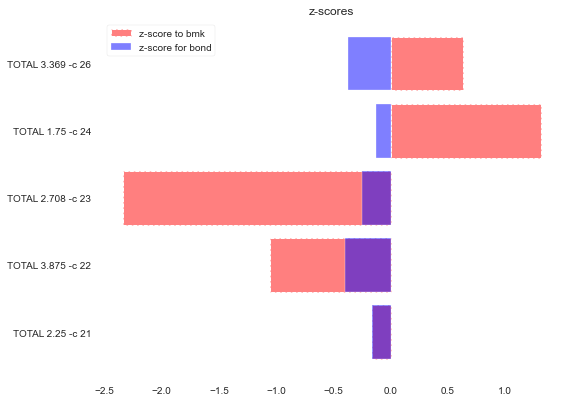

In [47]:
# plot some of the new data

fig, axs = plt.subplots()
axs.barh(bond_df_spd_to_bmk_df['bonds'],bond_df_spd_to_bmk_df['z-score spd_to_bmk'],  
                         label='z-score to bmk', fc=(1, 0, 0, 0.5),ls='dashed', lw=1)
axs.barh(bond_df_spd_to_bmk_df['bonds'],bond_df_spd_to_bmk_df['z-score'],  
                         label='z-score for bond', fc=(0, 0, 1, 0.5))
plt.legend()
plt.tight_layout()
plt.title('z-scores')
plt.show()





# to do comments

    1. curve at a point in history, say 60 days ago, 120 days ago. [done for spreads]
    2. plot current point on mean, variance bar chart. [see box+whiskers]
    3. use cmap and colour bar for additional dimension (also use size).
    4. curve fitting - best fit or smooth curve / polynomial between lines.






# Blank line

# Blank line


## Get historic data from file

In [48]:


def getIsinHistoryFrom_File():
    '''
    function to get ISIN history from a file
    '''


    # import XLSX data file
    dir_path = os.path.abspath('')

    # get items from sheet (in a sub folder)
    fileToGet = 'hybrid_BBG_raw.xlsx'


    # join file and correct folder
    fileToGet = os.path.join(dir_path, 'dataFolder', 'xlsxData', fileToGet)
    print(fileToGet)
    print('getting the file')

    xl = pd.ExcelFile(fileToGet)

    print('got the file')


    # the names of the available sheets
    print('getting security list from:', xl.sheet_names)

    # print(type(xl))
    for name in xl.sheet_names:
        bhDF = xl.parse(name)
    
    # print(bhDF)
    return bhDF



df = getIsinHistoryFrom_File()
df




C:\Users\darren\OneDrive - Redhedge\code\bbg\corpHybrids\dataFolder\xlsxData\hybrid_BBG_raw.xlsx
getting the file
got the file
getting security list from: ['BBGhistV']


date XS1323897485 XS0992293901 BE6309987400 XS1323897725  \
0   2020-08-03            -            -            -            -   
1   2020-08-02            -            -            -            -   
2   2020-08-01            -            -            -            -   
3   2020-07-31        2e+02        3e+02        3e+02        3e+02   
4   2020-07-30        2e+02        3e+02        3e+02        3e+02   
..         ...          ...          ...          ...          ...   
726 2018-08-08        2e+02        3e+02            -        3e+02   
727 2018-08-07        2e+02        3e+02            -        3e+02   
728 2018-08-06        2e+02        3e+02            -        3e+02   
729 2018-08-05            -            -            -            -   
730 2018-08-04            -            -            -            -   

    DE000A14J611 DE000A11QR73 XS2077670003 XS2077670342 XS2182055009  ...  \
0              -            -            -            -            -  ...   
1              -            -            -            -            -  ...   
2              -            -            -            -            -  ...   
3          2e+02        3e+02        3e+02        3e+02        3e+02  ...   
4          2e+02        3e+02        3e+02        3e+02        3e+02  ...   
..           ...          ...          ...          ...          ...  ...   
726        2e+02        2e+02            -            -            -  ...   
727        2e+02        2e+02            -            -            -  ...   
728        2e+02        2e+02            -            -            -  ...   
729            -            -            -            -            -  ...   
730            -            -            -            -            -  ...   

    XS1982704824 XS1934875219 XS0222524372 FR0011606169 XS1268050397  \
0          6e+02            -            -            -            -   
1              -            -            -            -            -   
2              -            -            -            -            -   
3          5e+02        1e+03            -        3e+03            -   
4          5e+02        1e+03            -        3e+03            -   
..           ...          ...          ...          ...          ...   
726            -            -            -        6e+03        1e+02   
727            -            -            -        5e+03        1e+02   
728            -            -            -        5e+03        1e+02   
729            -            -            -            -            -   
730            -            -            -            -            -   

    DE000A1ZN206 XS1582433428 XS2033327854 XS1642682410 XS1642686676  
0              -        1e+03        9e+02        7e+02        7e+02  
1              -            -            -            -            -  
2              -            -            -            -            -  
3          4e+02        1e+03        9e+02        7e+02        7e+02  
4          4e+02        1e+03        9e+02        7e+02        7e+02  
..           ...          ...          ...          ...          ...  
726        2e+02        6e+02            -        5e+02        5e+02  
727        2e+02        6e+02            -        5e+02        5e+02  
728        2e+02        6e+02            -        5e+02        5e+02  
729            -            -            -            -            -  
730            -            -            -            -            -  

[731 rows x 197 columns]

# Now get the bond data


In [49]:
# put all isin's in a list
isin = bond_df.iloc[:,0].tolist()
securtiyList = [x + " Corp" for x in isin]
print(securtiyList)

# make the lists unique (and keep the order)
securtiyList = list(collections.OrderedDict.fromkeys(securtiyList))

# get the data from bloomberg
print('getting data from bbg')
bondData = getListDataFromBbg(securtiyList, fieldList)
print('the data is collected')


['XS1195201931 Corp', 'XS1195202822 Corp', 'XS1413581205 Corp', 'XS1501166869 Corp', 'XS1501167164 Corp', 'XS1974787480 Corp']
getting data from bbg
the data is collected


In [50]:
# We can inspect the shape ofthe data here
bondData.shape

(6, 20)

In [51]:
bondData

id_isin ticker coupon nxt_call_dt    mty_typ px_mid  \
XS1195201931 Corp  XS1195201931  TOTAL      2  2021-02-26  PERP/CALL  1e+02   
XS1195202822 Corp  XS1195202822  TOTAL      3  2025-02-26  PERP/CALL  1e+02   
XS1413581205 Corp  XS1413581205  TOTAL      4  2022-05-18  PERP/CALL  1e+02   
XS1501166869 Corp  XS1501166869  TOTAL      3  2026-10-06  PERP/CALL  1e+02   
XS1501167164 Corp  XS1501167164  TOTAL      3  2023-05-05  PERP/CALL  1e+02   
XS1974787480 Corp  XS1974787480  TOTAL      2  2024-04-04  PERP/CALL  1e+02   

                  z_sprd_mid yas_ispread yas_bond_yld yas_risk crncy  \
XS1195201931 Corp      1e+02       1e+02          0.7      0.5   EUR   
XS1195202822 Corp      2e+02       2e+02            1        4   EUR   
XS1413581205 Corp      1e+02       1e+02          0.7        2   EUR   
XS1501166869 Corp      2e+02       2e+02            1        6   EUR   
XS1501167164 Corp      1e+02       1e+02            1        3   EUR   
XS1974787480 Corp      2e+02       2e+02            1        4   EUR   

                      payment_rank industry_sector rtg_moody rtg_sp  \
XS1195201931 Corp  Jr Subordinated          Energy        A2     A-   
XS1195202822 Corp  Jr Subordinated          Energy        A2     A-   
XS1413581205 Corp  Jr Subordinated          Energy        A2     A-   
XS1501166869 Corp  Jr Subordinated          Energy        A2     A-   
XS1501167164 Corp  Jr Subordinated          Energy        A2     A-   
XS1974787480 Corp  Jr Subordinated          Energy        A2     A-   

                  yas_mod_dur workout_dt_years_tdy reset_idx basic_spread  \
XS1195201931 Corp         0.5                  0.5     EUSA5            2   
XS1195202822 Corp           4                    5     EUSA5            2   
XS1413581205 Corp           2                    2     EUSA5            4   
XS1501166869 Corp           5                    6     EUSA5            3   
XS1501167164 Corp           3                    3     EUSA5            3   
XS1974787480 Corp           3                    4     EUSA5            2   

                  amt_outstanding  
XS1195201931 Corp           1e+09  
XS1195202822 Corp           2e+09  
XS1413581205 Corp           2e+09  
XS1501166869 Corp           2e+09  
XS1501167164 Corp           1e+09  
XS1974787480 Corp           2e+09

In [52]:
if bondData.shape[0] / len(isin):
    # remove duplicaes
    print('more rows than isins')
    bondData.drop_duplicates()

bondData.shape[0]



more rows than isins


6

# Time to save the Data to file



In [53]:
def store_data(someData):
    ''' function to store data to file 
    
    if data is stored:
        return: True otherwise False
    '''

    dataWritten = False

    # location to store file
    pathToStore = os.path.abspath('')
    # use a subfolder callled data folder
    pathToStore = os.path.join(pathToStore, 'dataFolder')
    print(f'the file resides here: {pathToStore}')

    # file name
    fileDateTime = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
    

    fileToStoreXLSX = 'hybrids_results ' + fileDateTime + '.xlsx'
    fileToStoreHTML = 'hybrids_results ' + fileDateTime + '.html'
    print(f'the name of the excel file: {fileToStoreXLSX}')
    print(f'the name of the HTML file: {fileToStoreHTML}')

    # full path name
    fullPathToStoreXLSX = os.path.join(pathToStore, fileToStoreXLSX)
    fullPathToStoreHTML = os.path.join(pathToStore, fileToStoreHTML)    
    
    # save the file (to excel and html)
    df = pd.DataFrame(someData)
    df.to_excel(fullPathToStoreXLSX)
    df.to_html(fullPathToStoreHTML)
    dataWritten = True


    return dataWritten

In [54]:
# run the function to store data

storeIt = store_data(bondData)
if storeIt == True:
    print('the data is stored')
    
    

the file resides here: C:\Users\darren\OneDrive - Redhedge\code\bbg\corpHybrids\dataFolder
the name of the excel file: hybrids_results 2020-08-26 16_55_49.xlsx
the name of the HTML file: hybrids_results 2020-08-26 16_55_49.html
the data is stored


# Lets draw some example charts now

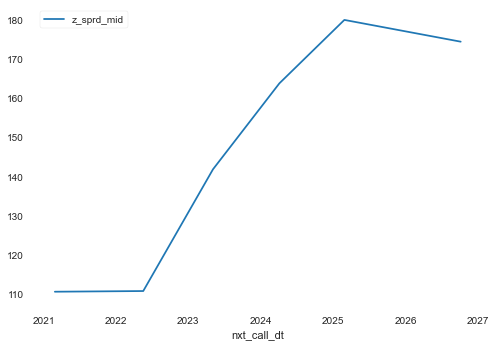

In [55]:
# plot maturity vs spread as a simple example directly from pandas
#bondData.plot(x='nxt_call_dt', y='z_sprd_mid',kind='scatter')
bondData.plot(x='nxt_call_dt',y='z_sprd_mid')



### a vertical bar chart

time taken:  0.03


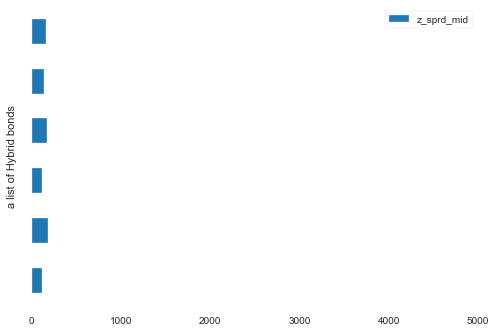

In [56]:
# plot a bar chart of the same data
# bondData.plot.bar(x='nxt_call_dt',y='z_sprd_mid')
t1 = time.time()


chart = bondData.plot(x='nxt_call_dt',y='z_sprd_mid', kind='barh')
chart.set_xlim(0,5000)

# change the y label
chart.set_ylabel('a list of Hybrid bonds')

# remove the y tick labels
chart.set_yticklabels([])




t2 = time.time()
print('time taken: ',round(t2-t1,2))





In [57]:
#bondData.hist(x='nxt_call_dt',y='z_sprd_mid')



### a histogram of the z spreads in the hybrid space

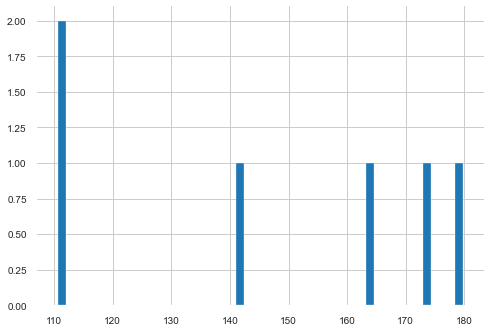

In [58]:
# convert to numeric
z_sprd_mid = pd.to_numeric(bondData['z_sprd_mid'])
yas_ispread = pd.to_numeric(bondData['yas_ispread'])


df = pd.DataFrame({
    'yas_ispread': yas_ispread,
    'z_sprd_mid':z_sprd_mid
    })

#hist = df['yas_ispread'].hist(bins=50)
#hist1 = df['z_sprd_mid'].hist(bins=50)


hist3 = bondData['z_sprd_mid'].hist(bins=50)




# Here are some statistics


In [59]:
# the average spread
x= bondData['z_sprd_mid'].mean()
x = round(x, 2)
print('the average z spread is:', x)


y= bondData['z_sprd_mid'].std()
y = round(y)
print('the standard deviation is:', y)

x, y = bondData['z_sprd_mid'].min() , bondData['z_sprd_mid'].max()
x, y = round(x), round(y)
print('min, max = ', x,",", y)

s = bondData['z_sprd_mid'].sem()
s = round(s,2)
print('standard error', s)



the average z spread is: 146.82
the standard deviation is: 31.0
min, max =  111 , 180
standard error 12.61


# lets get a regression

use the linear regression model in sklearn to get the linear regression.
example is here:


In [60]:
# linear regression

reg = linear_model.LinearRegression()

dependentVariables = bondData['nxt_call_dt'].values.reshape((-1,1))
independentVariables = bondData['z_sprd_mid'].values

# reg.fit(reg.fit([[0, 0], [1, 1], [2, 2]], [0, 1, 2]))

# model = reg.fit(dependentVariables,independentVariables)
# print(model)



# bonds crossing one year
This will be moved to a new module specifically for corporate hybrids.


In [61]:
# this will be moved to the hybrids module.



In [62]:
# oneYearBonds(bondData)

In [63]:
# delete the module so that it can be restarted for testing.
if 'hybridsMethods' in sys.modules:
    print('hybridsMethods was loaded')
    del sys.modules["hybridsMethods"]
    print('the module is now removed')


In [64]:
# import the hybrids module for testing
import hybridsMethods as hm

In [65]:

hm.oneYearBonds(100)



the hybrids module has been invoked
new things


0

# Other not used code...


In [66]:
def examples():
    """
    examples of how to get basic data from bbg
    """

    # get some data for a single name
    x = blp.bdp('BDEV LN Equity', 'px_last')
    print(x)
    print('the type of x', type(x))
    print('the value of x:', x.iloc[0]['px_last'])


    # get multiple data for a single name
    y = blp.bdp('BDEV LN Equity', flds=['px_bid', 'px_ask'])
    print(y)


    # get multiple data for multiple names
    z = blp.bdp(tickers=['BDEV LN Equity', 'BARC LN Equity'], flds=['px_bid', 'px_ask'])
    print(z)
    print('here is the bdev ask >>>', z.loc['BDEV LN Equity','px_ask'])

    # get multiple data for multiple names
    z = blp.bdp(tickers=['XS2011260705 Corp'], flds=['z_sprd_mid', 'z_sprd_mid'])
    print(z)
    print('here is the bdev ask >>>', z.loc['XS2011260705 Corp','z_sprd_mid'])

examples()


                px_last
BDEV LN Equity    517.2
the type of x <class 'pandas.core.frame.DataFrame'>
the value of x: 517.2
                px_bid  px_ask
BDEV LN Equity   517.2   517.4
                px_bid  px_ask
BARC LN Equity   110.4   110.4
BDEV LN Equity   517.2   517.4
here is the bdev ask >>> 517.4
                   z_sprd_mid  z_sprd_mid_1
XS2011260705 Corp       216.2         216.2
here is the bdev ask >>> 216.20728452041362


In [67]:
def get_bonds():
    """
    function to get bond data from bloomberg using tickers in an excel sheet.

    return:
        data - a pandas data set
    """

    print('getting bond data...')
    # securtiyList = ['US29265WAA62 Corp', 'XS1713463559 Corp', 'XS2000719992 Corp', 'XS0954675129 Corp', 'XS0954675129 Corp']
    fieldList = ['ticker', 'coupon', 'nxt_call_dt', 'final_maturity', 
                'mty_typ', 'px_mid', 'z_sprd_mid', 'yas_ispread', 'yas_bond_yld', 
                'yas_risk','crncy', 'payment_rank', 'industry_sector','rtg_moody','rtg_sp']

    # the script fis here
    #dir_path = os.path.dirname(os.path.realpath(__file__))
    dir_path = os.path.abspath('')


    # get items from sheet (in the same folder)
    fileToGet = 'hybridSecurityList.xlsx'
    # join file and correct folder
    fileToGet = os.path.join(dir_path, fileToGet)
    secListXlsx = pd.ExcelFile(fileToGet)
    
    # the names of the available sheets
    print('getting security list from:', secListXlsx.sheet_names)
    df = pd.DataFrame(secListXlsx.parse('tickers'))
    print('summary of the data')
    print(df.info)
    
    # put all isin's in a list
    isin = df.iloc[:,1].tolist()
    securtiyList = [x + " Corp" for x in isin]

    # make the lists unique (and keep the order)
    securtiyList = list(collections.OrderedDict.fromkeys(securtiyList))

    # get the data from bloomberg
    print('getting data from bbg')
    bondData = getListDataFromBbg(securtiyList, fieldList)

    #print('number of columns:', data.head())
    print('data is fetched:')
    print(bondData.info)

    return bondData

In [68]:
def main():

    # measure time for some basic examples
    t1 = time.time()
    
    # basic example (not used now)
    #examples()
    
    bondData = get_bonds()    
    t2 = time.time()

    # save data to file
    isStored = store_data(bondData)

    t3 = time.time()


    print('the time take is:', round(t2-t1, 3) , 'seconds')


In [69]:
# this works the same in a jupyter notebook which runs commands in sequence.
# there is no hoisting unless the code is added to a main() function.


if __name__ == "__main__":
    #main()
    pass




In [70]:
# os.system('jupyter nbconvert --to html hybridsAnalysis 03.ipynb')


-1